# Group 19: Phase 2 - Cats vs Dogs Detector (CaDoD)

## Team Members

We are a group of 4 members: 

Aishwarya Sinhasane - avsinhas@iu.edu (In picture, Left top) 

Himanshu Joshi - hsjoshi@iu.edu (In picture, Right bottom) 

Sreelaxmi Chakkadath - schakkad@iu.edu (In picture, Left bottom) 

Sumitha Vellinalur Thattai - svtranga@iu.edu (In picture, Right top) 



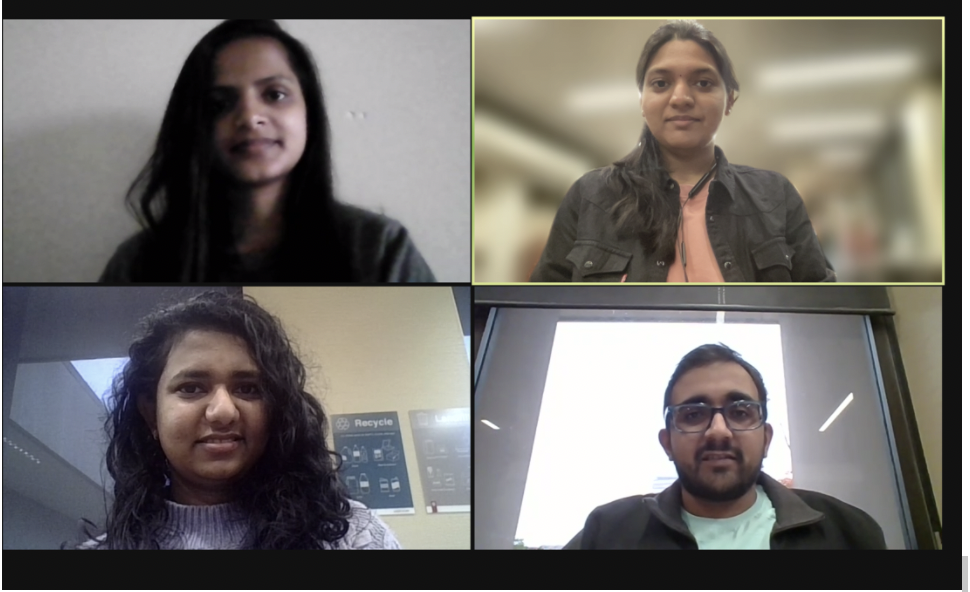


## Project Abstract

The objective of our project is to classify images as either dogs or cats. Additionally, we also plan to find where the cat/dog is in the image. Although the task is simple to human eyes, computers find it hard to distinguish between images because of a plethora of factors including cluttered background, illumination conditions, deformations, occlusions among several others. We plan to build an end-to-end machine learning model which will help computers differentiate between cat and dog images with better accuracy.

In our previous phase, we finalized using Gradient boosting and linear regression as our baseline for image detection and boundary box detection respectively. In this phase, we extended the baseline and implemented a complex loss function (CXE + MSE) using homegrown linear and logistic regression. 

Furthermore, we built multi-layered perceptron and calculated the accuracy and loss per epoch for classification and regression tasks. We have used data augmentation, dropout layers and regularization to overcome overfitting. In addition to this, we built a multi-headed predictor that calculates the combined loss function from classification and the regression tasks and uses it to optimize the weights and bias of the network.

Accuracy and loss are our primary evaluation parameters. In addition to this, we also used classification report (F1 score) and confusion matrix to evaluate the classification model. Using the above model, we got an accuracy of ~60% for classification and MSE close to zero for regression.


## Project Meta Data

We have completed the following task this week: 

- Homegrown linear regression 

- Complex loss function (CXE + MSE) using homegrown models 

 - Built sequential neural network for image classification and used the following to improve accuracy 

     - Data Augmentation 

    - Dropout layers 

    - Regularization 

- Built sequential neural network for boundary detection 
- Compare the performance of the above models using Accuracy and loss 
- Built a multi-headed cat-dog detector using the OOP API that combines loss function: CXE + MSE 
- Implemented convolutional neural network for image classification and box detection 


## Data Description


The data we plan to use is the Kaggle data set. We will be using two files – one for image and the other for boundary: 

The images are taken from the cadod.tar.gz 

The boundary information of the images is from cadod.csv file 

- There are about ~13k images in the data set. There is a good balance of classes with ~6.8K cat images and ~6.1K dog images in the data set. 

Image information (cadod.tar.gz): 

- There are ~13K images of various sizes and aspect ratios. Majority of the images are of 512 X 384 size 

- All the images are in RGB scale  

- The boundaries of the images are stored in the cadod.csv file 

Attributes of the Boundary File (cadod.csv): 

- This has information about the image box coordinates 

- There are about 20 features in this data set 

-15 numerical features 

    - This includes the image ID, the coordinates of the boundary boxes, and also the normalized coordinates of the boundary boxes 

-5 categorical features 

    -This gives information about the occlusion, depiction, truncation, etc. 

## Task

The following are the end-to-end task to achieve the results: 

- Image pre-processing (Augmentation) 

    - Augmentation involved flipping and rotation 

- Use sequential models to build neural networks 

- Neural network classifier for image detection 
- Neural network regressor for box detection 

- Implemented the above using OOP API and created a combined loss function (CXE + MSE) 

- Build a convolutional neural network 

Since the data set is very large, we have carried out the above tasks were carried out only in a subset of data. Hence the results will be only directional and not accurate 

In [1]:
from collections import Counter
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
import tarfile
from tqdm import tqdm
import warnings
import seaborn as sns
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Import Data

### Unarchive data

In [36]:
def extract_tar(file, path):
    """
    function to extract tar.gz files to specified location
    
    Args:
        file (str): path where the file is located
        path (str): path where you want to extract
    """
    with tarfile.open(file) as tar:
        files_extracted = 0
        for member in tqdm(tar.getmembers()):
            if os.path.isfile(path + member.name[1:]):
                continue
            else:
                tar.extract(member, path)
                files_extracted += 1
        tar.close()
        if files_extracted < 3:
            print('Files already exist')

In [37]:
path = 'images/'

# extract_tar('cadod.tar.gz', path)

### Load bounding box meta data

In [38]:
df = pd.read_csv('cadod.csv')

In [39]:
df.head()

ImageID  Source  LabelName  Confidence      XMin      XMax  \
0  0000b9fcba019d36  xclick  /m/0bt9lr           1  0.165000  0.903750   
1  0000cb13febe0138  xclick  /m/0bt9lr           1  0.000000  0.651875   
2  0005a9520eb22c19  xclick  /m/0bt9lr           1  0.094167  0.611667   
3  0006303f02219b07  xclick  /m/0bt9lr           1  0.000000  0.999219   
4  00064d23bf997652  xclick  /m/0bt9lr           1  0.240938  0.906183   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.268333  0.998333           1            1  ...            0         0   
1  0.000000  0.999062           1            1  ...            0         0   
2  0.055626  0.998736           1            1  ...            0         0   
3  0.000000  0.998824           1            1  ...            0         0   
4  0.000000  0.694286           0            0  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.636250  0.903750  0.748750  0.165000  0.268333  0.506667  0.998333   
1  0.312500  0.000000  0.317500  0.651875  0.000000  0.410882  0.999062   
2  0.487500  0.611667  0.243333  0.094167  0.055626  0.226296  0.998736   
3  0.508594  0.999219  0.000000  0.478906  0.000000  0.375294  0.720000   
4  0.678038  0.906183  0.240938  0.522388  0.000000  0.370000  0.424286   

   XClick4Y  
0  0.661667  
1  0.999062  
2  0.305942  
3  0.998824  
4  0.694286  

[5 rows x 21 columns]

# Preprocess

## Rescale the images

In [40]:
!mkdir -p images/resized

In [ ]:
%%time
# resize image and save, convert to numpy

img_arr = np.zeros((df.shape[0],128*128*3)) # initialize np.array

for i, f in enumerate(tqdm(df.ImageID)):
    img = Image.open(path+f+'.jpg')
    img_resized = img.resize((128,128))
    img_resized.save("images/resized/"+f+'.jpg', "JPEG", optimize=True)
    img_arr[i] = np.asarray(img_resized, dtype=np.uint8).flatten()

 25%|██▌       | 3263/12966 [04:09<53:44,  3.01it/s]   

Plot the resized and filtered images

In [ ]:
# plot random 6 images
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(df.shape[0], size=6, replace=False)):
    img = mpimg.imread(path+'/resized/'+df.ImageID.values[j]+'.jpg')
    h, w = img.shape[:2]
    coords = df.iloc[j,4:8]
    ax[i].imshow(img)
    ax[i].set_title(df.iloc[j,2])
    ax[i].add_patch(plt.Rectangle((coords[0]*w, coords[2]*h), 
                                  coords[1]*w-coords[0]*w, coords[3]*h-coords[2]*h, 
                                  edgecolor='red', facecolor='none'))

plt.tight_layout()
plt.show()

In [ ]:
# encode labels
df['Label'] = (df.LabelName == 'dog').astype(np.uint8)

## Checkpoint and Save data

In [ ]:
mkdir -p data

In [ ]:
np.save('data/img.npy', img_arr.astype(np.uint8))
np.save('data/y_label.npy', df.Label.values)
np.save('data/y_bbox.npy', df[['XMin', 'YMin', 'XMax', 'YMax']].values.astype(np.float32))

# Baseline in SKLearn

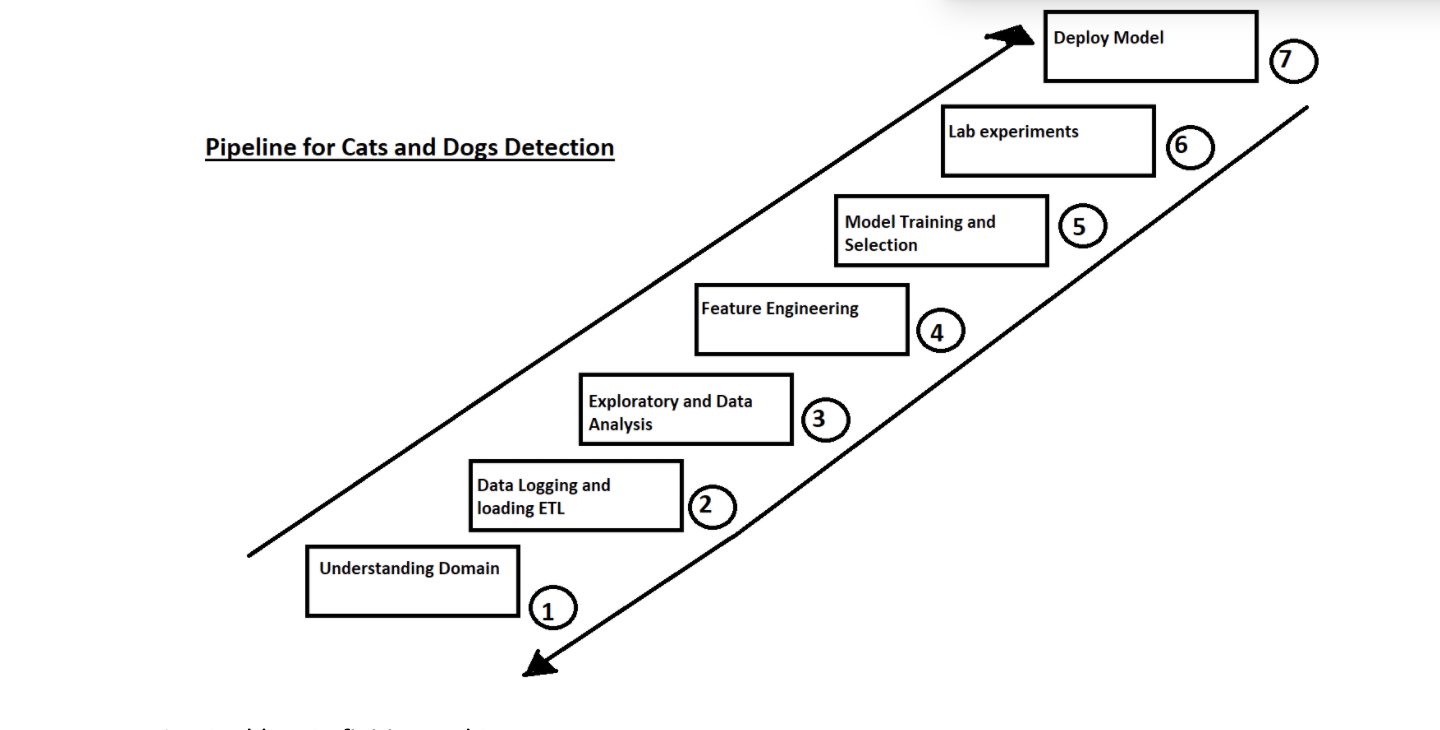


### Metrics for evaluation: 

- Accuracy - the ratio of correction predictions to the total predictions 

    Accuracy = (True Cats + True Dogs) / (True Cats + False Cats + True Dogs + False Dogs) 

    Confusion matrix – Gives us F1 score = 2*precision * recall / (precision + recall) 

    Recall is the ratio of true positives to all actual positives 

    Recall = True positives / (True positives + False negatives) 

    Precision is the ratio of true positives to all predicted positives 

    Precision = True positives / (True positives + False positives) 

- F1 score metric weights both recall and precision equally and thereby a higher value of recall and precision will ensure superior performance of the model 

### Loss function
- Cross entropy loss function for classification and MSE for regression were used as loss function for the neural network 

## Load data

In [2]:
X = np.load('data/img.npy', allow_pickle=True)
y_label = np.load('data/y_label.npy', allow_pickle=True)
y_bbox = np.load('data/y_bbox.npy', allow_pickle=True)

In [3]:
idx_to_label = {1:'dog', 0:'cat'} # encoder

Double check that it loaded correctly

In [4]:
# plot random 6 images
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(X.shape[0], size=6, replace=False)):
    coords = y_bbox[j] * 128
    ax[i].imshow(X[j].reshape(128,128,3))
    ax[i].set_title(idx_to_label[y_label[j]])
    ax[i].add_patch(plt.Rectangle((coords[0], coords[1]), 
                                  coords[2]-coords[0], coords[3]-coords[1], 
                                  edgecolor='red', facecolor='none'))

plt.tight_layout()
plt.show()

# Homegrown CXE + MSE

- We have built a homegrown logistic regression for image classification which gives the CXE loss at each epoch. Similarly, we have built a homegrown linear regression for boundary box detection which gives the MSE for each epoch.  

- The errors from both models are them combines to give us a complex loss function CXE + MSE which was then used to make predictions. 

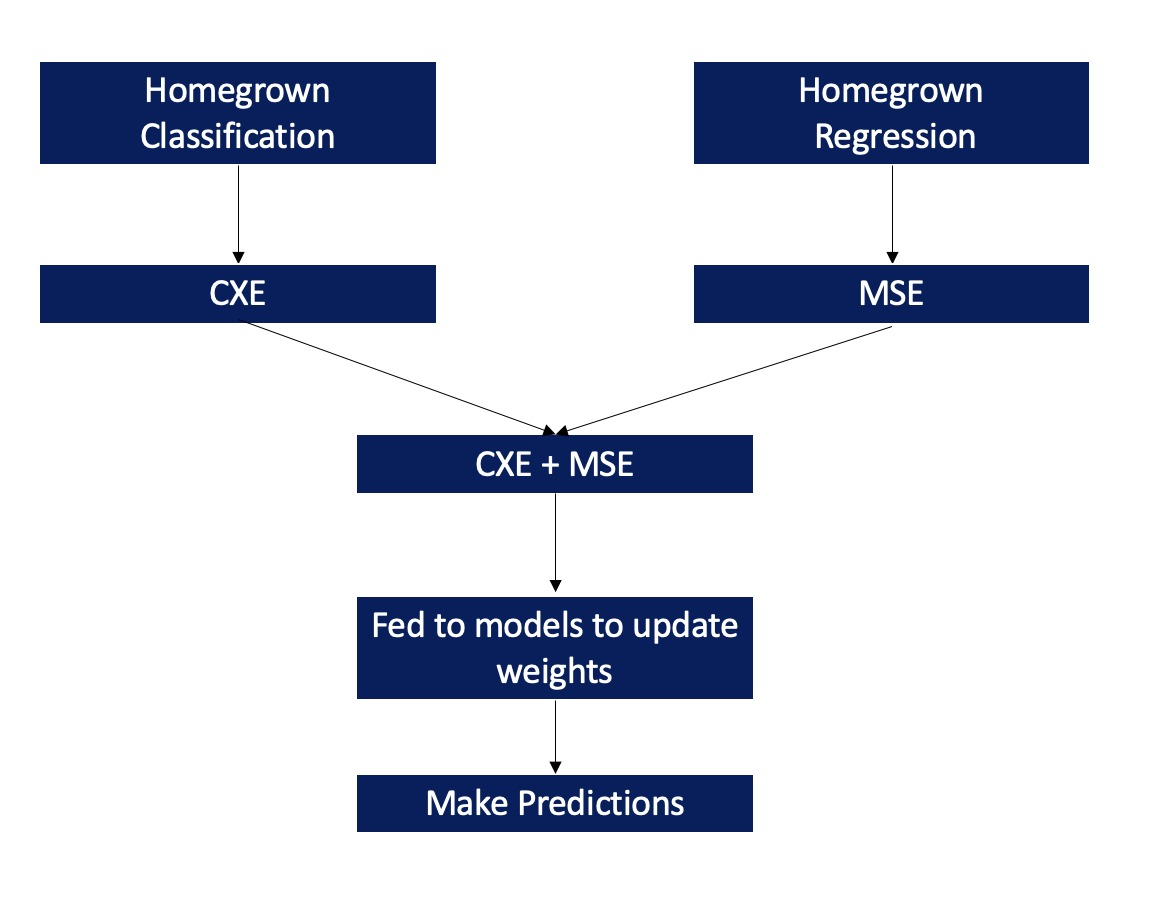


# Homegrown Linear Regression

## Linear Regression Loss Function

The mean square function formula is as follows : 
$
\text{MSE}({\mathbf{\theta}}; \mathbf{X}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{( \hat{y_i}  - y_i)^2}
$

where $m$  is the number of data points , $\hat{y_i}$ is the predicted value

### Split data

In [5]:
import random
random.seed(10)
idxs = random.sample(range(0, X.shape[0]), 500)
X_final = X[idxs]
y_label_final = y_label[idxs]

In [6]:
X_final = X[idxs]
y_bbox_final = y_bbox[idxs]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_bbox_final, test_size=0.01, random_state=27)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=27)

# np.random.seed(42)
# if np.max(X_train) > 4.:
#     X_train = X_train.astype(np.float32) / 255.
# if np.max(X_test) > 4.:
#     X_test = X_test.astype(np.float32) / 255.
#y_train=y_train.astype(int)
#y_test=y_test.astype(int)


In [8]:
from sklearn.preprocessing import MinMaxScaler, Normalizer
scaler = Normalizer(norm = 'l1')
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid) #Transform test set with the same constants
#X_test = scaler.transform(X_test) #Transform test set with the same constants

### Train

In [9]:
#Source - HW -5 
class BasicLinearRegressionHomegrown(object):
    
    def __init__(self, l1_reg = 0.0, l2_reg = 0.01):
        self.coef_ = None       # weight vector
        self.intercept_ = None  # bias term
        self._theta = None      # augmented weight vector, i.e., bias + weights
                                # this allows to treat all decision variables homogeneously
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg
        self.history = {"cost": [], 
                        'val_cost':[],
                        "coef": [], 
                        "intercept": [], 
                        "grad": []}
        
    def _grad(self, X, y):
        """
        Calculate the gradient of the objective function

        Args:
            X(ndarray):        train objects
            y(ndarray):        answers for train objects
        Return:
            gradient(ndarray): analytical gradient vector
        """
        pred = np.dot(X, self._theta)
        error = pred - y
        gradient = 2 * np.dot(error, X) / X.shape[0]
        gradient[1:] += 2 * self.l2_reg * self._theta[1:] + self.l1_reg * np.sign(self._theta[1:])
        return gradient
    
    # full gradient descent, i.e., not stochastic gd
    def _gd(self, X, y, max_iter, X_val, y_val, alpha = 0.003):
        """
        Runs GD and logs error, weigths, gradient at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
            alpha(floar):    step size in direction of gradient
        Return:
            None
        """
        for i in range(max_iter):
            
            self.history["coef"].append(self._theta[1:].copy())
            self.history["intercept"].append(self._theta[0].copy())
            
            mse = self.score(X, y)
            self.history["cost"].append(mse)
            
            if X_val is not None:
                mse = self.score(X_val, y_val)
                self.history["val_cost"].append(mse)
                
            # calculate gradient
            grad = self._grad(X, y)
            self.history["grad"].append(grad)
            
            # do gradient step
            self._theta -= alpha * grad
    
    def fit(self, X, y, max_iter=100, val_data = None):
        """
        Public API for fitting a linear regression model

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
        Return:
            self
        """
        # Augment the data with the bias term.
        # So we can treat the the input variables and the bias term homogeneously 
        # from a vectorization perspective
        X = np.c_[np.ones(X.shape[0]), X]
        # initialize if the first step
        if val_data is not None:
            X_val, y_val = val_data
            X_val = np.c_[np.ones(X_val.shape[0]), X_val]
        else:
            X_val = None
            y_val = None
            
        if self._theta is None:
            self._theta = np.random.rand(X.shape[1])
        
        # do full gradient descent
        self._gd(X, y, max_iter, X_val, y_val)
        
        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]
        return self
        
    def MSE(self, X, y, y_pred):
        error = y - y_pred
        mse = (np.sum(error ** 2)) / X.shape[0] 
        return mse
    
    def score(self, X, y):
        pred = self.predict(X)
        error = y - pred
        mse = (np.sum(error ** 2)) / X.shape[0] 
        return mse
        
    def predict(self, X):
        """
        Make a prediction

        Args:
            X(ndarray):      objects
        Return:
            pred(ndarray):   predictions
        """
        # check whether X has appended bias feature or not
        if X.shape[1] == len(self._theta):
            pred = np.dot(X, self._theta)
        else:
            pred = np.dot(X, self.coef_) + self.intercept_
        #print(pred)
        return pred

In [10]:
model_homegrown = BasicLinearRegressionHomegrown(l1_reg = 0, l2_reg = 0.0)

In [11]:
#Training the model for the 4 boundaries
np.random.seed(42)

model_homegrown.fit(X_train, y_train[:,0], max_iter=2000, val_data=(X_valid, y_valid[:,0])) 
y_pred1 = np.array([model_homegrown.predict(X_train)])
cost1_train = model_homegrown.history["cost"]
cost1_val = model_homegrown.history["val_cost"]

model_homegrown = BasicLinearRegressionHomegrown(l1_reg = 0, l2_reg = 0.0)
model_homegrown.fit(X_train, y_train[:,1], max_iter=2000,val_data=(X_valid, y_valid[:,1]))
y_pred2 = np.array([model_homegrown.predict(X_train)])
cost2_train = model_homegrown.history["cost"]
cost2_val = model_homegrown.history["val_cost"]

model_homegrown = BasicLinearRegressionHomegrown(l1_reg = 0, l2_reg = 0.0)
model_homegrown.fit(X_train, y_train[:,2], max_iter=2000,val_data=(X_valid, y_valid[:,2]))
y_pred3 = np.array([model_homegrown.predict(X_train)])
cost3_train = model_homegrown.history["cost"]
cost3_val = model_homegrown.history["val_cost"]

model_homegrown = BasicLinearRegressionHomegrown(l1_reg = 0, l2_reg = 0.0)
model_homegrown.fit(X_train, y_train[:,3], max_iter=2000,val_data=(X_valid, y_valid[:,3]))
y_pred4 = np.array([model_homegrown.predict(X_train)])
cost4_train = model_homegrown.history["cost"]
cost4_val = model_homegrown.history["val_cost"]

y_pred_test1 = np.array([model_homegrown.predict(X_train)])
y_pred_test2 = np.array([model_homegrown.predict(X_train)])
y_pred_test3 = np.array([model_homegrown.predict(X_train)])
y_pred_test4 = np.array([model_homegrown.predict(X_train)])

In [13]:
y_pred_train = np.concatenate((y_pred1, y_pred2,y_pred3,y_pred4),axis = 0)
y_pred_test = np.concatenate((y_pred_test1, y_pred_test2,y_pred_test3,y_pred_test4),axis = 0)
#y_pred_train
#y_pred_test

In [14]:
print(y_train.shape)
print(y_pred_train.T.shape)
print(y_pred_test.T.shape)

(445, 4)
(445, 4)
(445, 4)


### Evaluation

Mean Square Error:

- MSE gives how close our predicted regression line is to the data points
    - MSE = 1/n * Sum(True Value - Predicted value)^^2
    - Where n is the sample size

In [15]:
train_cost = np.sum((np.array(cost1_train), np.array(cost2_train), np.array(cost3_train), np.array(cost4_train)), axis = 0)
val_cost = np.sum((np.array(cost1_val), np.array(cost2_val), np.array(cost3_val), np.array(cost4_val)), axis = 0)

In [16]:
len(model_homegrown.history["val_cost"])

2000

In [17]:
plt.figure(figsize=(20, 8))
plt.suptitle("Homegrown Linear Regression")
plt.subplot(121)
plt.plot(train_cost, label="Train")
plt.plot(val_cost, label="Valid")
plt.legend(loc="upper left")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.xlim([0,100])
#plt.ylim([0.0, 0.3])

#plt.subplot(122)
plt.show()

# Homegrown implementation of Logistic Regression

Implement a Homegrown Logistic Regression model. Extend the loss function from CXE to CXE + MSE, i.e., make it a complex multitask loss function the resulting model   predicts the class and bounding box coordinates at the same time.

In [18]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test_label = train_test_split(X_final, y_label_final, test_size=0.01, random_state=27)
#s = StandardScaler()
#s.fit_transform(X_train)
#s.transform(X_test)


In [19]:
# Source - HW 7
class LogisticRegressionHomegrown(object):
    
    def __init__(self):
        """
        Constructor for the homgrown Logistic Regression
        
        Args:
            None
        
        Return:
            None
        """
        self.coef_ = None       
        self.intercept_ = None  
        self._theta = None      
                                
        self.history = {"cost": [], 
                        "acc": [], 
                        "val_cost":[], 
                        "val_acc": [],
                        'val_prob':[],
                       "prob":[]}
        
    def _grad(self, X, y):
        """
        Calculates the gradient of the Logistic Regression 
        objective function

        Args:
            X(ndarray):    train objects
            y(ndarray):    answers for train objects
            
        Return:
            grad(ndarray): gradient
        """
        
        n = X.shape[0]

        scores = self._predict_raw(X)

        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
 
        probs[range(n),y] -= 1
 
        gradient = np.dot(X.T, probs) / n
        
        return gradient
    
    def _gd(self, X, y, max_iter, alpha, X_val, y_val):

        for i in range(max_iter):
            
            metrics = self.score(X, y)
            self.history["cost"].append(metrics["cost"])
            self.history["acc"].append(metrics["acc"])
            self.history["prob"].append(metrics["prob"])
            
            if X_val is not None:
                metrics_val = self.score(X_val, y_val)
                self.history["val_cost"].append(metrics_val["cost"])
                self.history["val_acc"].append(metrics_val["acc"])
                self.history["val_prob"].append(metrics_val["prob"])

            # gradient
            grad = self._grad(X, y)
            

            self._theta -= alpha * grad
    
    def fit(self, X, y, max_iter=100, alpha=0.05, val_data=None):

        X = np.c_[np.ones(X.shape[0]), X]
        if val_data is not None:
            X_val, y_val = val_data
            X_val = np.c_[np.ones(X_val.shape[0]), X_val]
        else:
            X_val = None
            y_val = None
        
        if self._theta is None:
            self._theta = np.random.rand(X.shape[1], len(np.unique(y)))
        
        
        self._gd(X, y, max_iter, alpha, X_val, y_val)
        
        
        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]
        
    def score(self, X, y):

        n = X.shape[0]

        scores = self._predict_raw(X)
        
        
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        

        corect_logprobs = -np.log(probs[range(n),y])

        data_loss = np.sum(corect_logprobs) / n
        
        # predictions
        pred = np.argmax(scores, axis=1)
        # accuracy
        acc = accuracy_score(y, pred)

        metrics = {"acc": acc, "cost": data_loss, 'prob':corect_logprobs}
        
        return metrics
        
    def _predict_raw(self, X):

        if X.shape[1] == len(self._theta):
            scores = np.dot(X, self._theta)
        else:
            scores = np.dot(X, self.coef_) + self.intercept_
        return scores
    
    def predict(self, X):
        """
        Predicts class for each object in X
        
        Args:
            X(ndarray):      objects
        
        Return:
            pred(ndarray):   class for each object
        """
        # get scores for each class
        scores = self._predict_raw(X)
       
        pred = np.argmax(scores, axis=1)
        return pred

In [20]:
X_train, X_test, y_train, y_test_label = train_test_split(X_final, y_label_final, test_size=0.01, random_state=27)
np.random.seed(42)
if np.max(X_train) > 4.:
    X_train = X_train.astype(np.float32) / 255.
if np.max(X_test) > 4.:
    X_test = X_test.astype(np.float32) / 255.
y_train=y_train.astype(int)
y_test=y_test.astype(int)


In [21]:
class FixedLogisticRegressionHomegrown(LogisticRegressionHomegrown):
    
    def __init__(self):
        # call the constructor of the parent class
        super(FixedLogisticRegressionHomegrown, self).__init__()
        
    
    def _predict_raw(self, X):

        # check whether X has appended bias feature or not
        if X.shape[1] == len(self._theta):
            scores = np.dot(X, self._theta)
        else:
            scores = np.dot(X, self.coef_) + self.intercept_
        
        # normalize raw scores to prevent overflow
        scores -= np.max(scores, axis=1, keepdims=True)
        
        return scores

 



In [22]:

model_lr_homegrown_fixed = FixedLogisticRegressionHomegrown()

In [23]:
#Training model
model_lr_homegrown_fixed.fit(X_train, y_train, max_iter=2000, alpha=0.05, val_data=(X_test, y_test_label))

In [24]:
len(model_lr_homegrown_fixed.history["cost"])

2000

In [25]:
plt.figure(figsize=(20, 8))
plt.suptitle("Homegrown Logistic Regression")
#plt.subplot(121)
plt.plot(model_lr_homegrown_fixed.history["cost"], label="Train")
plt.plot(model_lr_homegrown_fixed.history["val_cost"], label="Test")
plt.legend(loc="upper left")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [26]:
y_pred_test = model_lr_homegrown_fixed.predict(X_test)

## Combined MSE and CXE loss.

- MSE calculated for boundary detection is combined here with CXE value. For each image data here we are calculating seperate MSE and CXE values and combining those will provide loss.

In [31]:
from sklearn.metrics import log_loss
def comb_MSE_CXE(y1,y2):
    sum_error = []
    for i in range(0, len(y1)):
        #y1_pred = model.predict([x[i]])
        #print(y1_pred)
        #y2_pred = y2[i]
        mse = y1[i]
        cxe = y2[i]
        sum1 = cxe + mse
        sum_error.append(sum1)
        #print(mse, cxe)
    return sum_error

In [32]:
sum_error_train = comb_MSE_CXE(train_cost, np.mean(model_lr_homegrown_fixed.history['prob'], axis = 1))

In [33]:
sum_error_valid = comb_MSE_CXE(val_cost, np.mean(model_lr_homegrown_fixed.history['val_prob'], axis = 1))

- Plotting data for combined values of MSE and CXE.

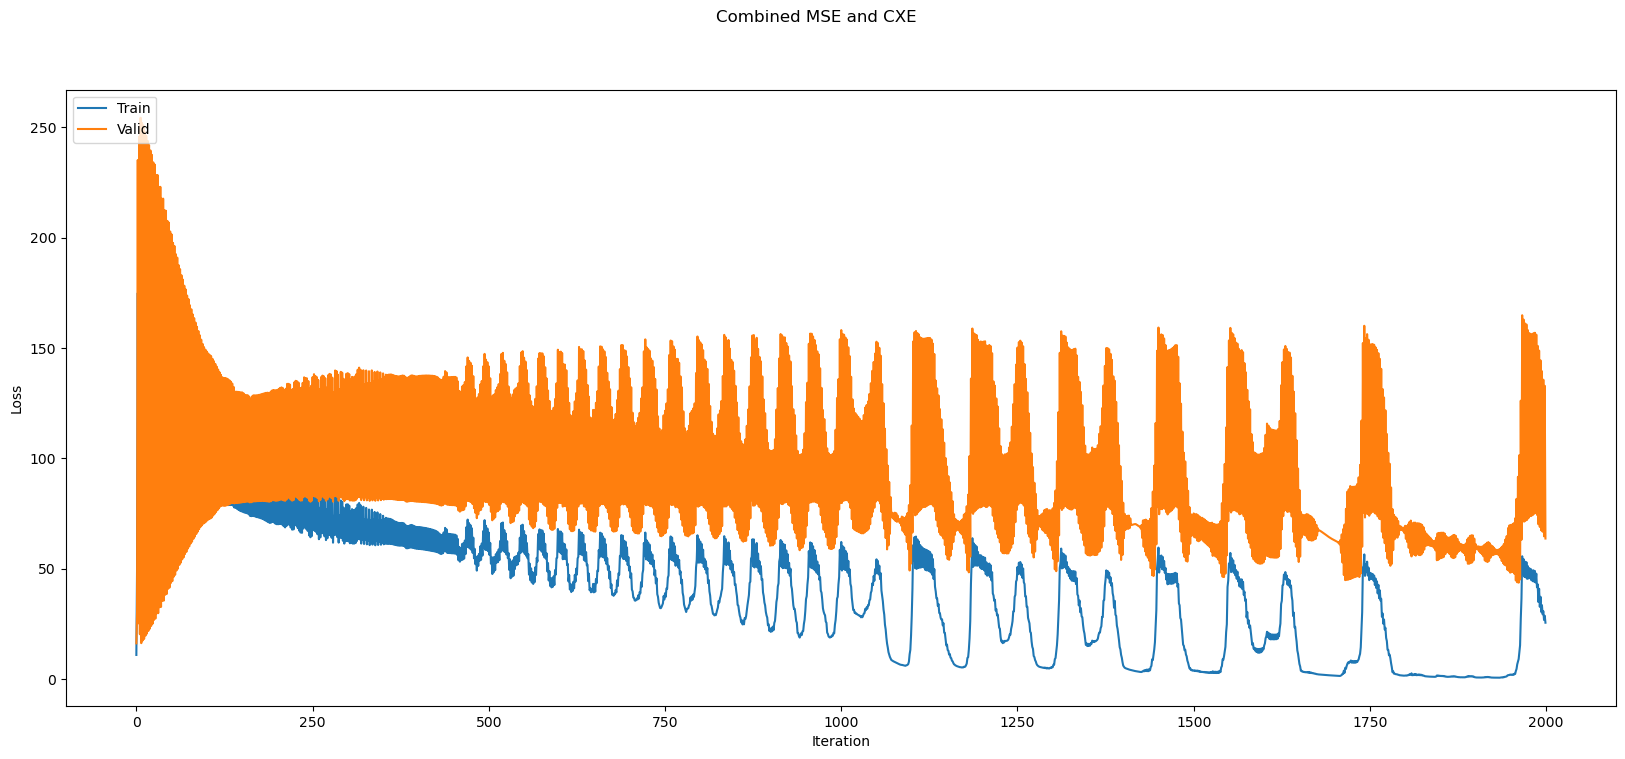

In [34]:
#Plotting combined loss
plt.figure(figsize=(20, 8))
plt.suptitle("Combined MSE and CXE")
#plt.subplot(121)
plt.plot(sum_error_train, label="Train")
plt.plot(sum_error_valid, label="Valid")
plt.legend(loc="upper left")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.show()

## Result: 

- Combined loss decreased steadily at each epoch 
- After around 100 epochs, the validation loss started to decrease at a higher rate

# Multi Layered Perceptron


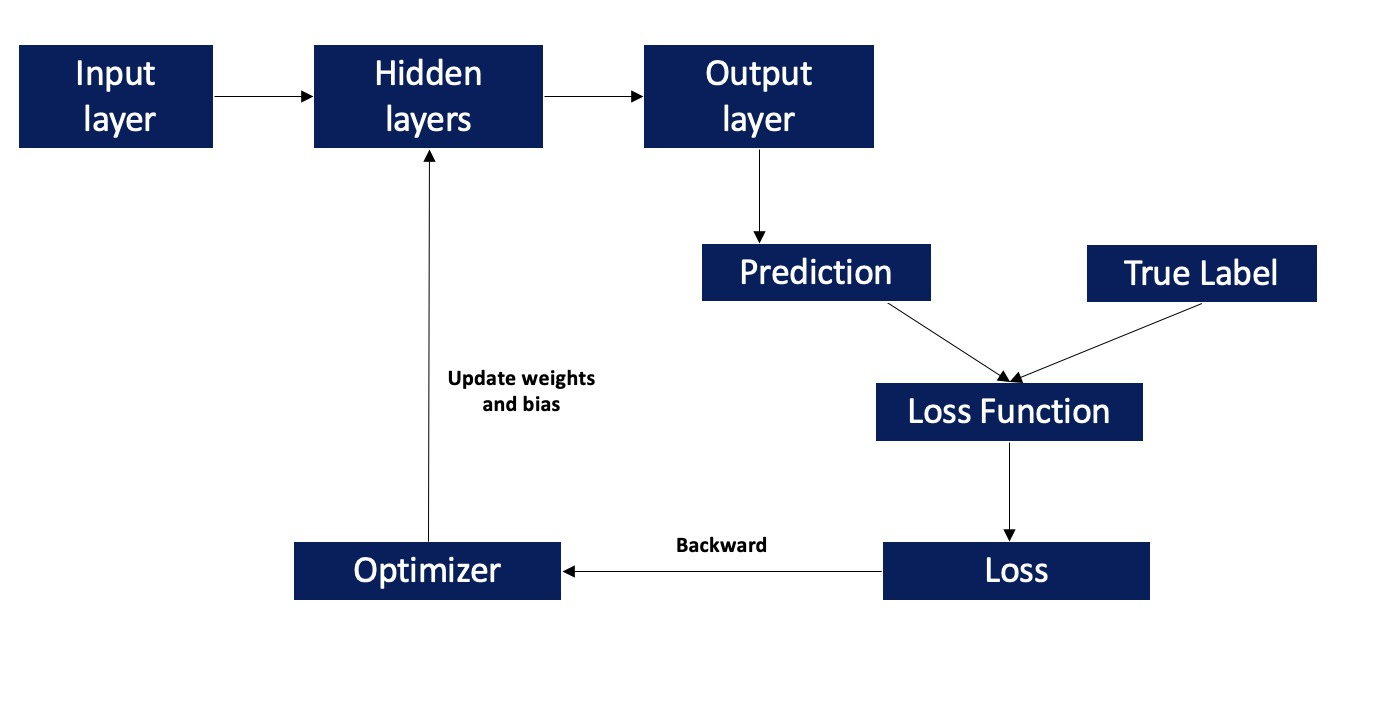

We will be using both sequential and class definition (OOP API) to build neural networks. 

- Sequential neural networks: 

    - In this method, we will pass all our connecting layers in the sequential class constructor itself 

- Class Definition (OOP API): 

    - To accomplish this in PyTorch you define a Model as a subclasses of torch.nn.Module. This model will include the following methods: 

     -__init__ method : Initialize the layers we want to use. We have to specify the sizes of our network in this method. We will also add all the layers we want to use in our network in this method 

    -forward method : We will specify the connections between the layers in this method. We will use the layers you already initialized in the __init__ method, in order to re-use the same layer for each forward pass of data 

- Classification: 

    - In both the above cases, we have split the data into train, validation, and test and used 30 epochs to help in the convergence process 

        - For image detection, we have used 1 input layer, 2 hidden layers and one output layer.  
        - ReLU has been used as the activation function and cross-entropy is the loss function.  
        - In addition to this, we have experimented with dropout layers. 
        - We are using Adam optimizer as an optimizer for convergence 

    -Regression: 

        - We have split the data into train, validation, and tests and used 50 epochs to help in the convergence process 
        - We have used 1 input layer, 2 hidden layer and 1 output layer to make the prediction for our four boundaries 
        -We have use tanh as our activation function 
        -Mean square is our loss function and we have experimented using stochastic gradient descent and adam as an optimizer for convergence 

## Image classification

### Sequential neural network classifier 

- Loss function used – Cross Entropy Loss function 

- We used a one input layer, 2 hidden layers, and an output layer in our neural network 

- ReLU was used as the activation function 

- We also used the following to experiments to avoid overfitting improve accuracy: 

    - Drop out layer With p values of 0.1 and 0.2 

    - Batch normalization after output of hidden layer 

    - We have used Adam optimizer with a learning rate of .0002 

    - We also used a weight decay value of 1e_4 which will provide us with L2 regularization 

### A similar process was followed for OOP as well 

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from torch.optim import Adam
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Setting seeds to try and ensure we have the same results - this is not guaranteed across PyTorch releases.
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, SubsetRandomSampler
import random
from os import listdir
from shutil import copyfile

In [4]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from os import makedirs

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

from google.colab import drive
drive.mount('/content/drive')

!ls "/content/drive/My Drive/Colab Notebooks"


In [6]:
random.seed(42)
X = np.load('data/img.npy', allow_pickle=True)
y_label = np.load('data/y_label.npy', allow_pickle=True)
y_bbox = np.load('data/y_bbox.npy', allow_pickle=True)

In [7]:
print(X.shape, y_label.shape)

(12966, 49152) (12966,)


In [8]:
#creating directories for test and train data set
dataset_home = 'cat_vs_dog/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['dogs/', 'cats/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		makedirs(newdir, exist_ok=True)

In [9]:
#load the csv file
df = pd.read_csv("cadod.csv")
df.head()


ImageID  Source  LabelName  Confidence      XMin      XMax  \
0  0000b9fcba019d36  xclick  /m/0bt9lr           1  0.165000  0.903750   
1  0000cb13febe0138  xclick  /m/0bt9lr           1  0.000000  0.651875   
2  0005a9520eb22c19  xclick  /m/0bt9lr           1  0.094167  0.611667   
3  0006303f02219b07  xclick  /m/0bt9lr           1  0.000000  0.999219   
4  00064d23bf997652  xclick  /m/0bt9lr           1  0.240938  0.906183   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.268333  0.998333           1            1  ...            0         0   
1  0.000000  0.999062           1            1  ...            0         0   
2  0.055626  0.998736           1            1  ...            0         0   
3  0.000000  0.998824           1            1  ...            0         0   
4  0.000000  0.694286           0            0  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.636250  0.903750  0.748750  0.165000  0.268333  0.506667  0.998333   
1  0.312500  0.000000  0.317500  0.651875  0.000000  0.410882  0.999062   
2  0.487500  0.611667  0.243333  0.094167  0.055626  0.226296  0.998736   
3  0.508594  0.999219  0.000000  0.478906  0.000000  0.375294  0.720000   
4  0.678038  0.906183  0.240938  0.522388  0.000000  0.370000  0.424286   

   XClick4Y  
0  0.661667  
1  0.999062  
2  0.305942  
3  0.998824  
4  0.694286  

[5 rows x 21 columns]

In [10]:
df.LabelName.replace({'/m/01yrx':'cat', '/m/0bt9lr':'dog'}, inplace=True)

In [11]:
df.head()

ImageID  Source LabelName  Confidence      XMin      XMax  \
0  0000b9fcba019d36  xclick       dog           1  0.165000  0.903750   
1  0000cb13febe0138  xclick       dog           1  0.000000  0.651875   
2  0005a9520eb22c19  xclick       dog           1  0.094167  0.611667   
3  0006303f02219b07  xclick       dog           1  0.000000  0.999219   
4  00064d23bf997652  xclick       dog           1  0.240938  0.906183   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.268333  0.998333           1            1  ...            0         0   
1  0.000000  0.999062           1            1  ...            0         0   
2  0.055626  0.998736           1            1  ...            0         0   
3  0.000000  0.998824           1            1  ...            0         0   
4  0.000000  0.694286           0            0  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.636250  0.903750  0.748750  0.165000  0.268333  0.506667  0.998333   
1  0.312500  0.000000  0.317500  0.651875  0.000000  0.410882  0.999062   
2  0.487500  0.611667  0.243333  0.094167  0.055626  0.226296  0.998736   
3  0.508594  0.999219  0.000000  0.478906  0.000000  0.375294  0.720000   
4  0.678038  0.906183  0.240938  0.522388  0.000000  0.370000  0.424286   

   XClick4Y  
0  0.661667  
1  0.999062  
2  0.305942  
3  0.998824  
4  0.694286  

[5 rows x 21 columns]

In [12]:
dog_list = df[df.LabelName == 'dog']['ImageID']
cat_list = df[df.LabelName == 'cat']['ImageID']
#list(dog_list)

In [13]:

# moving images to test and train folder

random.seed(10)
# define ratio of pictures to use for test
test_ratio = 0.20
count_c = 0
count_d = 0

# copy training dataset images into subdirectories
src_directory = 'cadod/'
for file in listdir(src_directory):
    #print(file.replace('.jpg','').replace('._','') in list(cat_list))
    #print(file.replace('.jpg','').replace('._','') in list(dog_list))
    src = src_directory + '/' + file
    dst_dir = 'train/'
    if random.random() < test_ratio:
        dst_dir = 'test/'
    if file.replace('.jpg','').replace('._','') in list(cat_list) and count_c < 2000:
        dst = dataset_home + dst_dir + 'cats/'  + file
        count_c +=1
        copyfile(src, dst)
    elif file.replace('.jpg','').replace('._','') in list(dog_list) and count_d < 2000:
        dst = dataset_home + dst_dir + 'dogs/'  + file
        count_d +=1
        copyfile(src, dst)

In [14]:
from tensorflow.keras import models
from tensorflow.keras.applications import *
from tensorflow.keras import layers



# Training MultiLayer Perceptron

# Image classification

# Sequential Neural Network Model

In [107]:
expLog1 = pd.DataFrame(columns=["exp_name", 
                               "Train Acc", 
                               "Valid Acc",
                               "Test  Acc",
                              ])

In [108]:
#Using nn.sequential to build a muti layer perceptron
from torch.optim import Adam
model = nn.Sequential(
nn.Flatten(),
nn.Linear(128*128*3, 128),
nn.ReLU(),
nn.BatchNorm1d(128),
 nn.Linear(128, 64),
nn.ReLU(),
nn.BatchNorm1d(64),   
    nn.Dropout(0.2),
    nn.Linear(64,2),
    nn.Softmax(dim = 1)
)

criterion = nn.CrossEntropyLoss() #loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay = 1e-3) # Optimizer with reularization
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [500,1000,1500], gamma = 0.5)

In [109]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [110]:
#Calcualtion if accuracy
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)    
    correct_results_sum = (y_pred_tags == y_test).sum().float()    
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)    
    return acc

In [111]:
model = model.to(device)
#optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()))

num_epochs = 25

#Test set 
for e in range(num_epochs):
    cum_epoch_loss = 0
    cum_acc = 0
    batch_loss = 0
    model.train()
    for batch, (images, labels) in enumerate(trainloader,1):

        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        label_pred = model(images).squeeze() #Fitting the model
        loss = criterion(label_pred, labels) #Calculating loss
        acc = binary_acc(label_pred, labels) #Calculating accuracy
        loss.backward() #back propagting the loss
        optimizer.step() #Modify weights and bias based on the loss
        batch_loss += loss.item()
        cum_acc += acc.item()
        scheduler.step()
       
    #Evaluating mode on validation set
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for batch, (X_val_batch, y_val_batch) in enumerate(valloader,1):
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)            
            y_val_pred = model(X_val_batch).squeeze()
            #y_val_pred = torch.unsqueeze(y_val_pred, 0)            
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch)            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
        #print(f'Epoch({e}/{num_epochs} : Train loss : {loss.item()} : Train Accuracy : {acc.item()} : Valid loss : {val_loss.item()} : Valid Accuracy : {val_acc.item()}')
    
    loss_stats['train'].append(batch_loss/len(trainloader))
    loss_stats['val'].append(val_epoch_loss/len(valloader))
    accuracy_stats['train'].append(cum_acc/len(trainloader))
    accuracy_stats['val'].append(val_epoch_acc/len(valloader))

    
    print(f'Epoch({e}/{num_epochs})')
    print(f'Training loss : {batch_loss/len(trainloader)}')  
    print(f'Training accuracy : {cum_acc/len(trainloader)}')  
    print(f'Validation loss : {val_epoch_loss/len(valloader)}')  
    print(f'Validation accuracy : {val_epoch_acc/len(valloader)}') 
    
        

    

Epoch(0/25)
Training loss : 0.7125498804640262
Training accuracy : 50.1063829787234
Validation loss : 0.6871637397342258
Validation accuracy : 54.62222222222222
Epoch(1/25)
Training loss : 0.693171889223951
Training accuracy : 53.0
Validation loss : 0.684539356496599
Validation accuracy : 54.6
Epoch(2/25)
Training loss : 0.6835525986996103
Training accuracy : 55.829787234042556
Validation loss : 0.6752279546525743
Validation accuracy : 58.355555555555554
Epoch(3/25)
Training loss : 0.68639815107305
Training accuracy : 55.61702127659574
Validation loss : 0.6795152836375766
Validation accuracy : 55.44444444444444
Epoch(4/25)
Training loss : 0.6779653873849423
Training accuracy : 57.06382978723404
Validation loss : 0.6744380593299866
Validation accuracy : 56.77777777777778
Epoch(5/25)
Training loss : 0.6795218282557548
Training accuracy : 56.723404255319146
Validation loss : 0.6762206421958076
Validation accuracy : 56.86666666666667
Epoch(6/25)
Training loss : 0.6784659750918125
Training 

In [112]:
#Plotting testing and validation accuracies
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))

sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable", ax = axes[0]).set_title('Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax = axes[1]).set_title('Loss/Epoch')
plt.show()

In [113]:
#Testing the model
y_pred_list = []
y_true_list = []
model.eval()
with torch.no_grad():
    num_correct = 0
    total = 0
    #set_trace()
    for batch, (images, labels) in enumerate(testloader,1):
        pred = model(images)
        #output = torch.exp(logps)
        pred = torch.argmax(pred, 1)
        y_pred_list.append(pred.numpy())
        y_true_list.append(labels.numpy())
        total += labels.size(0)
        num_correct += (pred == labels).sum().item()
        
        print(f'Batch ({batch}/{len(testloader)})')


    print(f'Accuracy of the model on {total} test images: {num_correct * 100 / total}% ')

Batch (1/49)
Batch (2/49)
Batch (3/49)
Batch (4/49)
Batch (5/49)
Batch (6/49)
Batch (7/49)
Batch (8/49)
Batch (9/49)
Batch (10/49)
Batch (11/49)
Batch (12/49)
Batch (13/49)
Batch (14/49)
Batch (15/49)
Batch (16/49)
Batch (17/49)
Batch (18/49)
Batch (19/49)
Batch (20/49)
Batch (21/49)
Batch (22/49)
Batch (23/49)
Batch (24/49)
Batch (25/49)
Batch (26/49)
Batch (27/49)
Batch (28/49)
Batch (29/49)
Batch (30/49)
Batch (31/49)
Batch (32/49)
Batch (33/49)
Batch (34/49)
Batch (35/49)
Batch (36/49)
Batch (37/49)
Batch (38/49)
Batch (39/49)
Batch (40/49)
Batch (41/49)
Batch (42/49)
Batch (43/49)
Batch (44/49)
Batch (45/49)
Batch (46/49)
Batch (47/49)
Batch (48/49)
Batch (49/49)
Accuracy of the model on 781 test images: 57.87451984635083% 


In [114]:
#Calulating the number of right and wring prediction to get the
#classification report and confusion matrix
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for batch, (images, labels) in enumerate(testloader,1):      
        y_test_pred = model(images)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)        
        y_pred_list = [*y_pred_list,*y_pred_tag.cpu().numpy()]
        y_true_list = [*y_true_list,*labels.cpu().numpy()]

In [115]:
#Logging the experiment
exp_name = f"Sequential Neural Network"
expLog1.loc[0,:4] = [f"{exp_name}"] + list(np.round(
               [accuracy_stats['train'][-1], 
                accuracy_stats['val'][-1],
                (num_correct * 100 / total)],3))
expLog1

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


exp_name Train Acc Valid Acc Test  Acc
0  Sequential Neural Network    62.872    56.733    57.875

In [116]:
y_pred_list_1 = np.array(y_pred_list).T
y_true_list_1 = np.array(y_true_list).T
#y_pred_list_1

In [117]:
print(classification_report(y_true_list_1, y_pred_list_1))

              precision    recall  f1-score   support

           0       0.61      0.50      0.55       402
           1       0.55      0.67      0.61       379

    accuracy                           0.58       781
   macro avg       0.58      0.58      0.58       781
weighted avg       0.58      0.58      0.58       781



In [118]:
print(confusion_matrix(y_true_list_1, y_pred_list_1))

[[199 203]
 [126 253]]


In [119]:
#Plot confusiion matrix
idx2class = {v: k for k, v in train_it.class_to_idx.items()}
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list_1, y_pred_list_1)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax, cmap = 'Blues', fmt = 'g')
plt.show()

# PyTorch OOP API Neural network

In [15]:
expLog = pd.DataFrame(columns=["exp_name", 
                               "Train Acc", 
                               "Valid Acc",
                               "Test  Acc",
                              ])

# Experiments

# Without Data Augmentation

In [16]:
#Normalizing image and converting to tensor

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform_test = transforms.Compose([
    #transforms.ToPILImage(),             
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])
transform_train = transforms.Compose([
    #transforms.ToPILImage(),             
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    #transforms.RandomAutocontrast()
    
    ])

In [17]:
#Loading the image
train_it = datasets.ImageFolder('cat_vs_dog/train/', transform=transform_train)
test_it = datasets.ImageFolder('cat_vs_dog/test/', transform=transform_test)

dataset_size = len(train_it)
dataset_indices = list(range(dataset_size))
np.random.shuffle(dataset_indices)

In [18]:
dataset_size

3219

In [19]:
train_set, val_set = torch.utils.data.random_split(train_it, [2500, 719]) 

In [20]:
#splitting data into train, validation and test
trainloader = DataLoader(train_set, batch_size=64, shuffle=True)
valloader = DataLoader(val_set, shuffle=True, batch_size=16)
testloader = DataLoader(test_it, batch_size=32, shuffle=True)

In [21]:
for images, labels in trainloader:
    print(images.size(), labels.size())
    print(labels)
    break

torch.Size([64, 3, 128, 128]) torch.Size([64])
tensor([1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1])


In [22]:
#defining neural network layers
class cadod(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(128*128*3, 128) # input layer
     
        self.fc4 = nn.Linear(128,64)
        self.fc5 = nn.Linear(64,2)
        self.relu = nn.ReLU() #activation function
        
        self.norm2 = nn.BatchNorm1d(512) #normalizing the output
        self.norm3 = nn.BatchNorm1d(128)
        self.norm4 = nn.BatchNorm1d(64)


    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))

        x = self.norm3(x)
        x = F.relu(self.fc4(x))
        x = self.norm4(x)
        #x =self.dropout(x)
        x = self.fc5(x) 
        x = F.softmax(x, dim = 1) # using softmax as activation layer for output
        return x

model = cadod()
criterion = nn.CrossEntropyLoss() #Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002) #optimizer with learning rate of 0.0002
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [500,1000,1500], gamma = 0.5)

In [23]:
#calculation of accuracy
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)    
    correct_results_sum = (y_pred_tags == y_test).sum().float()    
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)    
    return acc

In [24]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [25]:
model = model.to(device)
#optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()))

num_epochs = 50


for e in range(num_epochs):
    cum_epoch_loss = 0
    cum_acc = 0
    batch_loss = 0
    model.train()
    for batch, (images, labels) in enumerate(trainloader,1):

        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        label_pred = model(images).squeeze() #fitting the model

        loss = criterion(label_pred, labels) #calculation of loss
        acc = binary_acc(label_pred, labels) #calculation of accuracy
        loss.backward() #back propagation of loss
        optimizer.step() #Optimizing the weights and bias based on the loss value
        batch_loss += loss.item() #calculating cumulative loss
        cum_acc += acc.item() #calculating cumulative accuracy
        
    #using validation set to see if our model took the step in the right direction
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for batch, (X_val_batch, y_val_batch) in enumerate(valloader,1):
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)            
            y_val_pred = model(X_val_batch).squeeze()
                       
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch)            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
        #print(f'Epoch({e}/{num_epochs} : Train loss : {loss.item()} : Train Accuracy : {acc.item()} : Valid loss : {val_loss.item()} : Valid Accuracy : {val_acc.item()}')
    
    loss_stats['train'].append(batch_loss/len(trainloader))
    loss_stats['val'].append(val_epoch_loss/len(valloader))
    accuracy_stats['train'].append(cum_acc/len(trainloader))
    accuracy_stats['val'].append(val_epoch_acc/len(valloader))
    
    print(f'Epoch({e}/{num_epochs})')
    print(f'Training loss : {batch_loss/len(trainloader)}')  
    print(f'Training accuracy : {cum_acc/len(trainloader)}')  
    print(f'Validation loss : {val_epoch_loss/len(valloader)}')  
    print(f'Validation accuracy : {val_epoch_acc/len(valloader)}') 
    

Epoch(0/50)
Training loss : 0.7094970524311066
Training accuracy : 51.15
Validation loss : 0.68065847158432
Validation accuracy : 54.888888888888886
Epoch(1/50)
Training loss : 0.6562335282564163
Training accuracy : 63.15
Validation loss : 0.6780192547374302
Validation accuracy : 56.266666666666666
Epoch(2/50)
Training loss : 0.6370158970355988
Training accuracy : 66.475
Validation loss : 0.674514098962148
Validation accuracy : 59.044444444444444
Epoch(3/50)
Training loss : 0.6026391848921776
Training accuracy : 72.95
Validation loss : 0.6753588464525011
Validation accuracy : 56.44444444444444
Epoch(4/50)
Training loss : 0.5662027284502983
Training accuracy : 77.475
Validation loss : 0.6777131835619609
Validation accuracy : 57.8
Epoch(5/50)
Training loss : 0.5436086222529412
Training accuracy : 81.075
Validation loss : 0.6880022565523783
Validation accuracy : 55.8
Epoch(6/50)
Training loss : 0.5347298622131348
Training accuracy : 81.325
Validation loss : 0.6894654247495863
Validation a

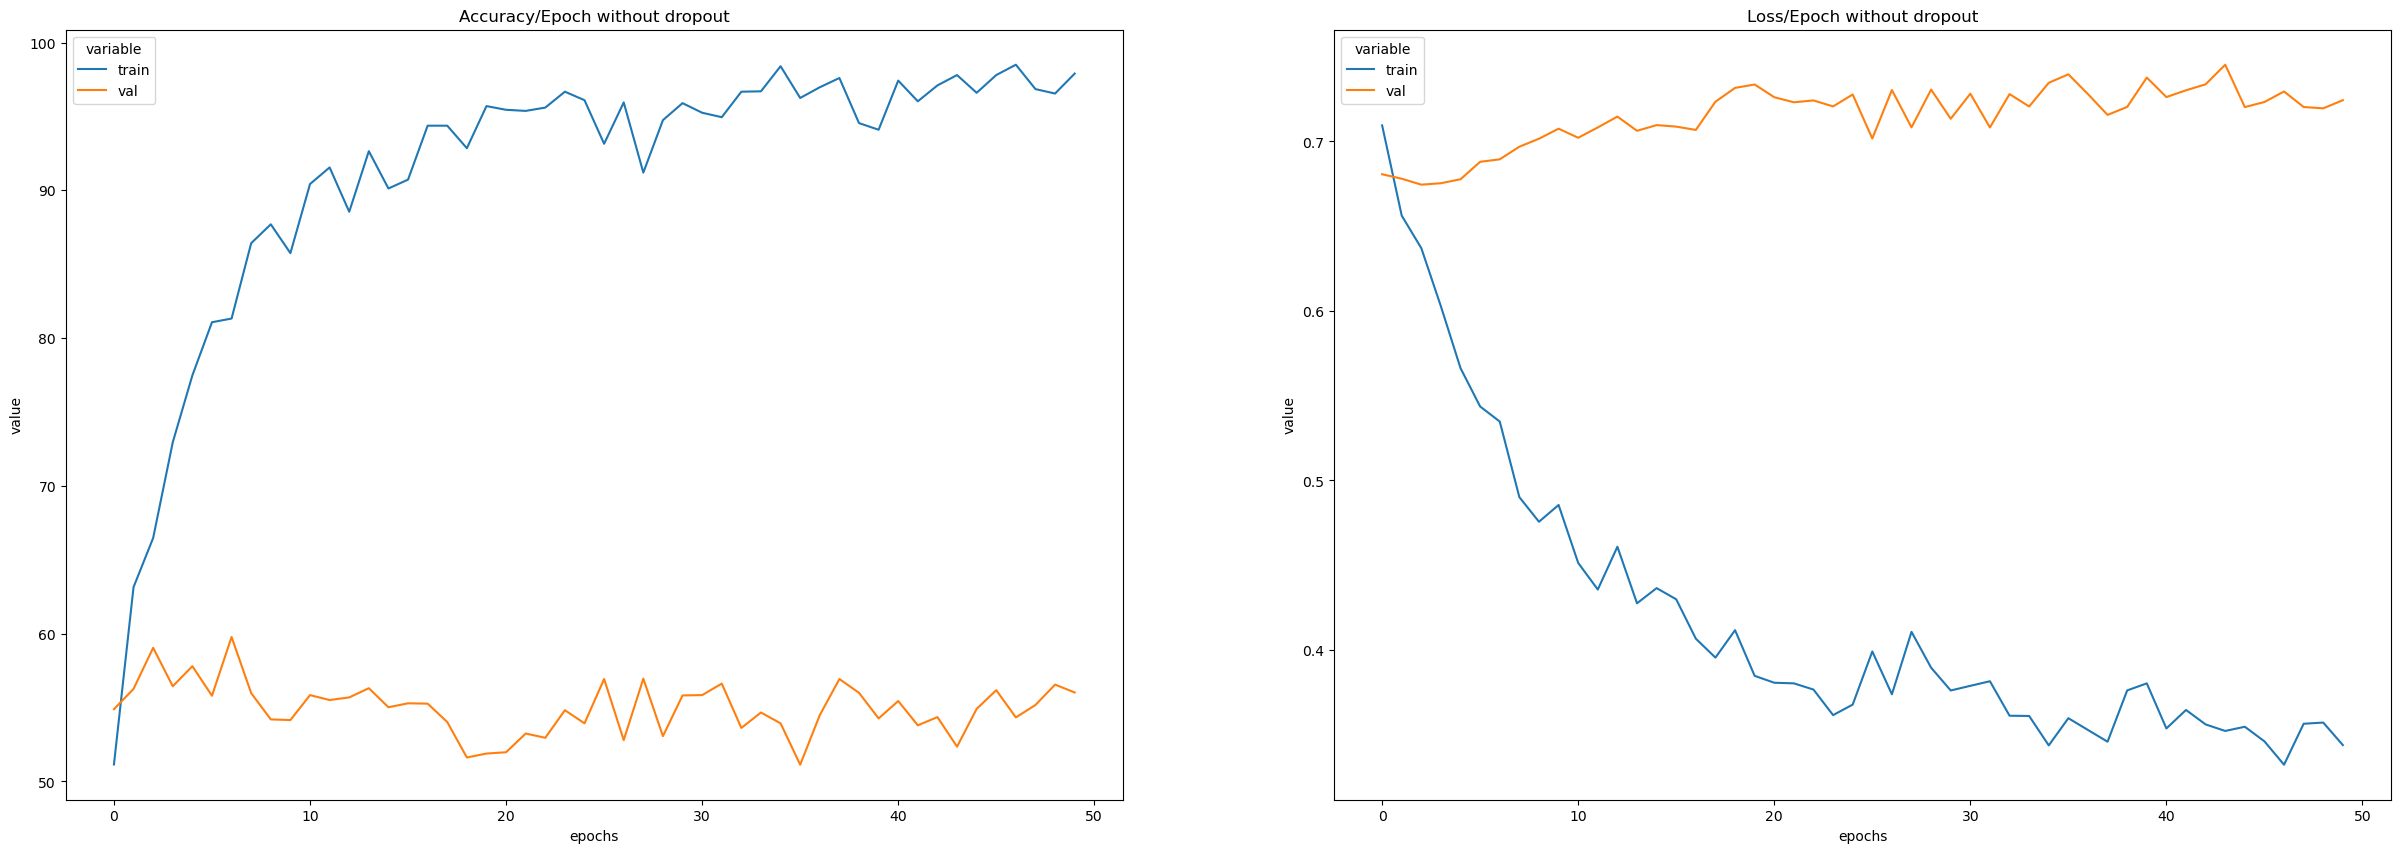

In [26]:
#plotting training and validation loss and accuracy
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))

sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable", ax = axes[0]).set_title('Accuracy/Epoch without dropout')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax = axes[1]).set_title('Loss/Epoch without dropout')
plt.show()

In [27]:
#Testing out model
y_pred_list = []
y_true_list = []
model.eval()
with torch.no_grad():
    num_correct = 0
    total = 0
    #set_trace()
    for batch, (images, labels) in enumerate(testloader,1):
        pred = model(images)
        pred = torch.argmax(pred, 1)
        y_pred_list.append(pred.numpy())
        y_true_list.append(labels.numpy())
        total += labels.size(0)
        num_correct += (pred == labels).sum().item()
        print(f'Batch ({batch}/{len(testloader)})')
        
        #if batch == 7:
            #break

    print(f'Accuracy of the model on {total} test images: {num_correct * 100 / total}% ')

Batch (1/25)
Batch (2/25)
Batch (3/25)
Batch (4/25)
Batch (5/25)
Batch (6/25)
Batch (7/25)
Batch (8/25)
Batch (9/25)
Batch (10/25)
Batch (11/25)
Batch (12/25)
Batch (13/25)
Batch (14/25)
Batch (15/25)
Batch (16/25)
Batch (17/25)
Batch (18/25)
Batch (19/25)
Batch (20/25)
Batch (21/25)
Batch (22/25)
Batch (23/25)
Batch (24/25)
Batch (25/25)
Accuracy of the model on 781 test images: 56.97823303457106% 


In [31]:
#Recording our experiment
exp_name = f"Baseline Neural Network without Augmentation, Regularization, Batchnorm and Dropout"
expLog.loc[0,:4] = [f"{exp_name}"] + list(np.round(
               [accuracy_stats['train'][-1], 
                accuracy_stats['val'][-1],
                (num_correct * 100 / total)],3))
expLog

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


exp_name Train Acc Valid Acc  \
0  Baseline Neural Network without Augmentation, ...      97.9    56.022   

  Test  Acc  
0    56.978

In [32]:
#calculating the absolute number of right and wrong classifcation to help us 
#get the classification report and confusion matrix
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for batch, (images, labels) in enumerate(testloader,1):      
        y_test_pred = model(images)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)        
        y_pred_list = [*y_pred_list,*y_pred_tag.cpu().numpy()]
        y_true_list = [*y_true_list,*labels.cpu().numpy()]

In [33]:
y_pred_list_1 = np.array(y_pred_list).T
y_true_list_1 = np.array(y_true_list).T
#y_pred_list_1

In [34]:
print(classification_report(y_true_list_1, y_pred_list_1))

              precision    recall  f1-score   support

           0       0.58      0.57      0.58       402
           1       0.55      0.57      0.56       379

    accuracy                           0.57       781
   macro avg       0.57      0.57      0.57       781
weighted avg       0.57      0.57      0.57       781



In [35]:
print(confusion_matrix(y_true_list_1, y_pred_list_1))

[[228 174]
 [162 217]]


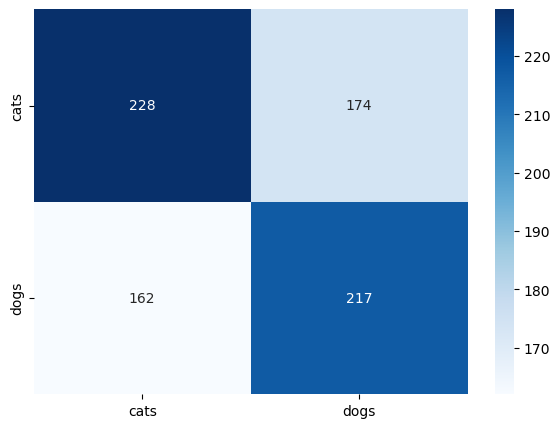

In [36]:
#Plotting the confusion matrix
idx2class = {v: k for k, v in train_it.class_to_idx.items()}
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list_1, y_pred_list_1)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax, cmap = 'Blues', fmt = 'g')
plt.show()

## With Regularization and Dropout

In [37]:
from torch.optim import Adam
class cadod(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(128*128*3, 128)
        #self.fc2 = nn.Linear(1024,512)
        #self.fc3 = nn.Linear(512,128)
        self.fc4 = nn.Linear(128,64)
        self.fc5 = nn.Linear(64,2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        #self.norm1 = nn.BatchNorm1d(1024)
        self.norm2 = nn.BatchNorm1d(512)
        self.norm3 = nn.BatchNorm1d(128)
        self.norm4 = nn.BatchNorm1d(64)


    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        #x = self.norm1(x)
        #x = F.relu(self.fc2(x))
        #x = self.norm2(x)
        #x = F.relu(self.fc3(x))
        x = self.norm3(x)
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.norm4(x)
        x = self.dropout(x)
        x = self.fc5(x) 
        x = F.softmax(x, dim = 1)
        return x

model = cadod()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, weight_decay = 3e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [500,1000,1500], gamma = 0.5)

In [38]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [39]:
model = model.to(device)
#optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()))

num_epochs = 50


for e in range(num_epochs):
    cum_epoch_loss = 0
    cum_acc = 0
    batch_loss = 0
    model.train()
    for batch, (images, labels) in enumerate(trainloader,1):
    #print(labels)
    #print(images.shape)
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        label_pred = model(images).squeeze()
        #print(logps)
        #break;
        #labels = labels.unsqueeze(1)
        loss = criterion(label_pred, labels)
        acc = binary_acc(label_pred, labels)
        loss.backward()
        optimizer.step()
        batch_loss += loss.item()
        cum_acc += acc.item()
        scheduler.step()
        #print(f'Epoch({e}/{num_epochs} : Batch number({batch}/{len(trainloader)})')
    
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for batch, (X_val_batch, y_val_batch) in enumerate(valloader,1):
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)            
            y_val_pred = model(X_val_batch).squeeze()
            #y_val_pred = torch.unsqueeze(y_val_pred, 0)            
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch)            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
        #print(f'Epoch({e}/{num_epochs} : Train loss : {loss.item()} : Train Accuracy : {acc.item()} : Valid loss : {val_loss.item()} : Valid Accuracy : {val_acc.item()}')
    
    loss_stats['train'].append(batch_loss/len(trainloader))
    loss_stats['val'].append(val_epoch_loss/len(valloader))
    accuracy_stats['train'].append(cum_acc/len(trainloader))
    accuracy_stats['val'].append(val_epoch_acc/len(valloader))
    
    print(f'Epoch({e}/{num_epochs})')
    print(f'Training loss : {batch_loss/len(trainloader)}')  
    print(f'Training accuracy : {cum_acc/len(trainloader)}')  
    print(f'Validation loss : {val_epoch_loss/len(valloader)}')  
    print(f'Validation accuracy : {val_epoch_acc/len(valloader)}') 
    

Epoch(0/50)
Training loss : 0.7061507776379585
Training accuracy : 51.375
Validation loss : 0.6786177966329786
Validation accuracy : 56.577777777777776
Epoch(1/50)
Training loss : 0.6667854681611061
Training accuracy : 58.9
Validation loss : 0.6765707095464071
Validation accuracy : 58.6
Epoch(2/50)
Training loss : 0.6524740591645241
Training accuracy : 61.575
Validation loss : 0.6764273669984605
Validation accuracy : 56.15555555555556
Epoch(3/50)
Training loss : 0.6436463922262192
Training accuracy : 63.875
Validation loss : 0.6758760372797649
Validation accuracy : 58.733333333333334
Epoch(4/50)
Training loss : 0.623135557770729
Training accuracy : 67.05
Validation loss : 0.6760422998004489
Validation accuracy : 56.77777777777778
Epoch(5/50)
Training loss : 0.6147623524069786
Training accuracy : 68.95
Validation loss : 0.6819179680612352
Validation accuracy : 55.48888888888889
Epoch(6/50)
Training loss : 0.5993827551603317
Training accuracy : 71.15
Validation loss : 0.6770801941553751


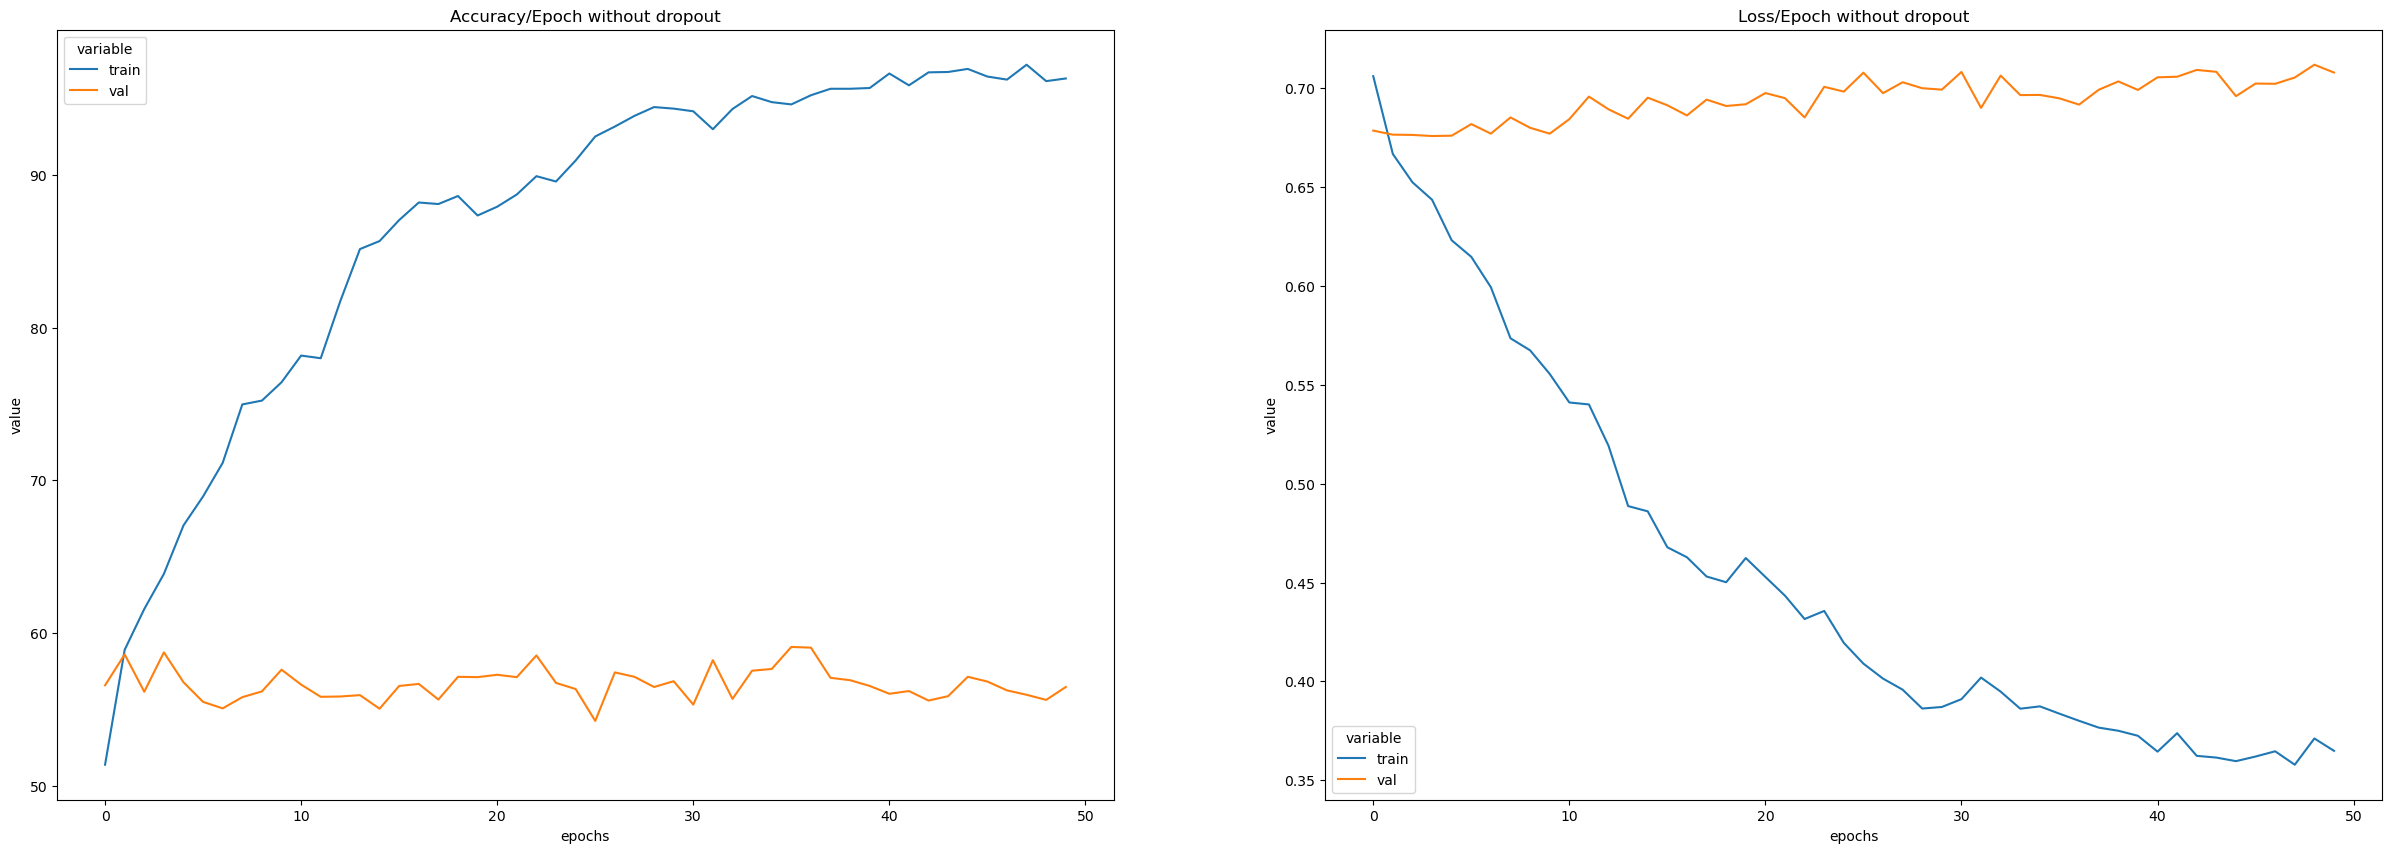

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))

sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable", ax = axes[0]).set_title('Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax = axes[1]).set_title('Loss/Epoch')
plt.show()

In [41]:
y_pred_list = []
y_true_list = []
model.eval()
with torch.no_grad():
    num_correct = 0
    total = 0
    #set_trace()
    for batch, (images, labels) in enumerate(testloader,1):
        pred = model(images)
        #output = torch.exp(logps)
        pred = torch.argmax(pred, 1)
        y_pred_list.append(pred.numpy())
        y_true_list.append(labels.numpy())
        total += labels.size(0)
        num_correct += (pred == labels).sum().item()
        #print('accuracy', binary_acc(pred, labels).item())
        print(f'Batch ({batch}/{len(testloader)})')
        
        #if batch == 7:
            #break

    print(f'Accuracy of the model on {total} test images: {num_correct * 100 / total}% ')

Batch (1/25)
Batch (2/25)
Batch (3/25)
Batch (4/25)
Batch (5/25)
Batch (6/25)
Batch (7/25)
Batch (8/25)
Batch (9/25)
Batch (10/25)
Batch (11/25)
Batch (12/25)
Batch (13/25)
Batch (14/25)
Batch (15/25)
Batch (16/25)
Batch (17/25)
Batch (18/25)
Batch (19/25)
Batch (20/25)
Batch (21/25)
Batch (22/25)
Batch (23/25)
Batch (24/25)
Batch (25/25)
Accuracy of the model on 781 test images: 57.10627400768246% 


In [42]:
exp_name = f"Neural Network without Augmentation and with Regularization and Dropout"
expLog.loc[1,:4] = [f"{exp_name}"] + list(np.round(
               [accuracy_stats['train'][-1], 
                accuracy_stats['val'][-1],
                (num_correct * 100 / total)],3))
expLog

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


exp_name Train Acc Valid Acc  \
0  Baseline Neural Network without Augmentation, ...      97.9    56.022   
1  Neural Network without Augmentation and with R...    96.325    56.467   

  Test  Acc  
0    56.978  
1    57.106

In [43]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for batch, (images, labels) in enumerate(testloader,1):      
        y_test_pred = model(images)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)        
        y_pred_list = [*y_pred_list,*y_pred_tag.cpu().numpy()]
        y_true_list = [*y_true_list,*labels.cpu().numpy()]

In [44]:
y_pred_list_1 = np.array(y_pred_list).T
y_true_list_1 = np.array(y_true_list).T
#y_pred_list_1

In [45]:
print(classification_report(y_true_list_1, y_pred_list_1))

              precision    recall  f1-score   support

           0       0.58      0.63      0.60       402
           1       0.56      0.51      0.53       379

    accuracy                           0.57       781
   macro avg       0.57      0.57      0.57       781
weighted avg       0.57      0.57      0.57       781



In [46]:
print(confusion_matrix(y_true_list_1, y_pred_list_1))

[[254 148]
 [187 192]]


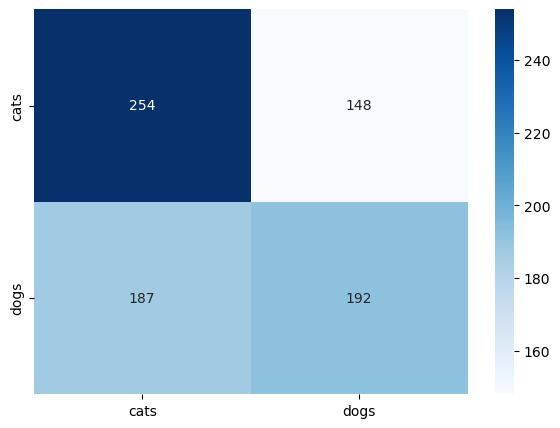

In [47]:
idx2class = {v: k for k, v in train_it.class_to_idx.items()}
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list_1, y_pred_list_1)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax, cmap = 'Blues', fmt = 'g')
plt.show()

### Data Augmentation

In [48]:
#Data augmentation
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform_test = transforms.Compose([
    #transforms.ToPILImage(),             
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])
transform_train = transforms.Compose([
    #transforms.ToPILImage(),             
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(40),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    #transforms.RandomAutocontrast()
    
    ])

In [49]:
train_it = datasets.ImageFolder('cat_vs_dog/train/', transform=transform_train)
test_it = datasets.ImageFolder('cat_vs_dog/test/', transform=transform_test)

dataset_size = len(train_it)
dataset_indices = list(range(dataset_size))
np.random.shuffle(dataset_indices)

In [50]:
dataset_size

3219

In [51]:
train_set, val_set = torch.utils.data.random_split(train_it, [2500, 719]) 

In [52]:
trainloader = DataLoader(train_set, batch_size=54, shuffle=True)
valloader = DataLoader(val_set, shuffle=True, batch_size=16)
testloader = DataLoader(test_it, batch_size=16, shuffle=True)

In [53]:
for images, labels in trainloader:
    print(images.size(), labels.size())
    print(labels)
    break

torch.Size([54, 3, 128, 128]) torch.Size([54])
tensor([0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
        1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
        0, 1, 0, 0, 1, 0])


In [54]:
for batch, (images, labels) in enumerate(trainloader,1):
    print(sum(labels))
    break

tensor(30)


# With Data Augmentation

# Without regularization and dropout

In [55]:
from torch.optim import Adam
class cadod(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(128*128*3, 128)
        #self.fc2 = nn.Linear(1024,512)
        #self.fc3 = nn.Linear(512,128)
        self.fc4 = nn.Linear(128,64)
        self.fc5 = nn.Linear(64,2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        #self.norm1 = nn.BatchNorm1d(1024)
        self.norm2 = nn.BatchNorm1d(512)
        self.norm3 = nn.BatchNorm1d(128)
        self.norm4 = nn.BatchNorm1d(64)


    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))

        x = self.norm3(x)
        x = F.relu(self.fc4(x))
        x = self.norm4(x)
        #x =self.dropout(x)
        x = self.fc5(x) 
        x = F.softmax(x, dim = 1)
        return x

model = cadod()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [500,1000,1500], gamma = 0.5)

In [56]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [57]:
model = model.to(device)
#optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()))

num_epochs = 50


for e in range(num_epochs):
    cum_epoch_loss = 0
    cum_acc = 0
    batch_loss = 0
    model.train()
    for batch, (images, labels) in enumerate(trainloader,1):
    #print(labels)
    #print(images.shape)
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        label_pred = model(images).squeeze()
        #print(logps)
        #break;
        #labels = labels.unsqueeze(1)
        loss = criterion(label_pred, labels)
        acc = binary_acc(label_pred, labels)
        loss.backward()
        optimizer.step()
        batch_loss += loss.item()
        cum_acc += acc.item()
        #scheduler.step()
        #print(f'Epoch({e}/{num_epochs} : Batch number({batch}/{len(trainloader)})')
    
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for batch, (X_val_batch, y_val_batch) in enumerate(valloader,1):
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)            
            y_val_pred = model(X_val_batch).squeeze()
            #y_val_pred = torch.unsqueeze(y_val_pred, 0)            
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch)            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
        #print(f'Epoch({e}/{num_epochs} : Train loss : {loss.item()} : Train Accuracy : {acc.item()} : Valid loss : {val_loss.item()} : Valid Accuracy : {val_acc.item()}')
    
    loss_stats['train'].append(batch_loss/len(trainloader))
    loss_stats['val'].append(val_epoch_loss/len(valloader))
    accuracy_stats['train'].append(cum_acc/len(trainloader))
    accuracy_stats['val'].append(val_epoch_acc/len(valloader))
    
    print(f'Epoch({e}/{num_epochs})')
    print(f'Training loss : {batch_loss/len(trainloader)}')  
    print(f'Training accuracy : {cum_acc/len(trainloader)}')  
    print(f'Validation loss : {val_epoch_loss/len(valloader)}')  
    print(f'Validation accuracy : {val_epoch_acc/len(valloader)}') 
    

Epoch(0/50)
Training loss : 0.69586806474848
Training accuracy : 54.08510638297872
Validation loss : 0.6855854153633117
Validation accuracy : 56.86666666666667
Epoch(1/50)
Training loss : 0.6864400341155681
Training accuracy : 56.297872340425535
Validation loss : 0.6852175182766385
Validation accuracy : 53.8
Epoch(2/50)
Training loss : 0.6826955536578564
Training accuracy : 55.93617021276596
Validation loss : 0.6779671774970161
Validation accuracy : 57.266666666666666
Epoch(3/50)
Training loss : 0.6778146459701213
Training accuracy : 56.61702127659574
Validation loss : 0.6752467685275607
Validation accuracy : 55.888888888888886
Epoch(4/50)
Training loss : 0.6754652134915615
Training accuracy : 57.787234042553195
Validation loss : 0.6792816585964627
Validation accuracy : 55.75555555555555
Epoch(5/50)
Training loss : 0.6676017324975196
Training accuracy : 59.04255319148936
Validation loss : 0.6839485155211554
Validation accuracy : 53.91111111111111
Epoch(6/50)
Training loss : 0.669075557

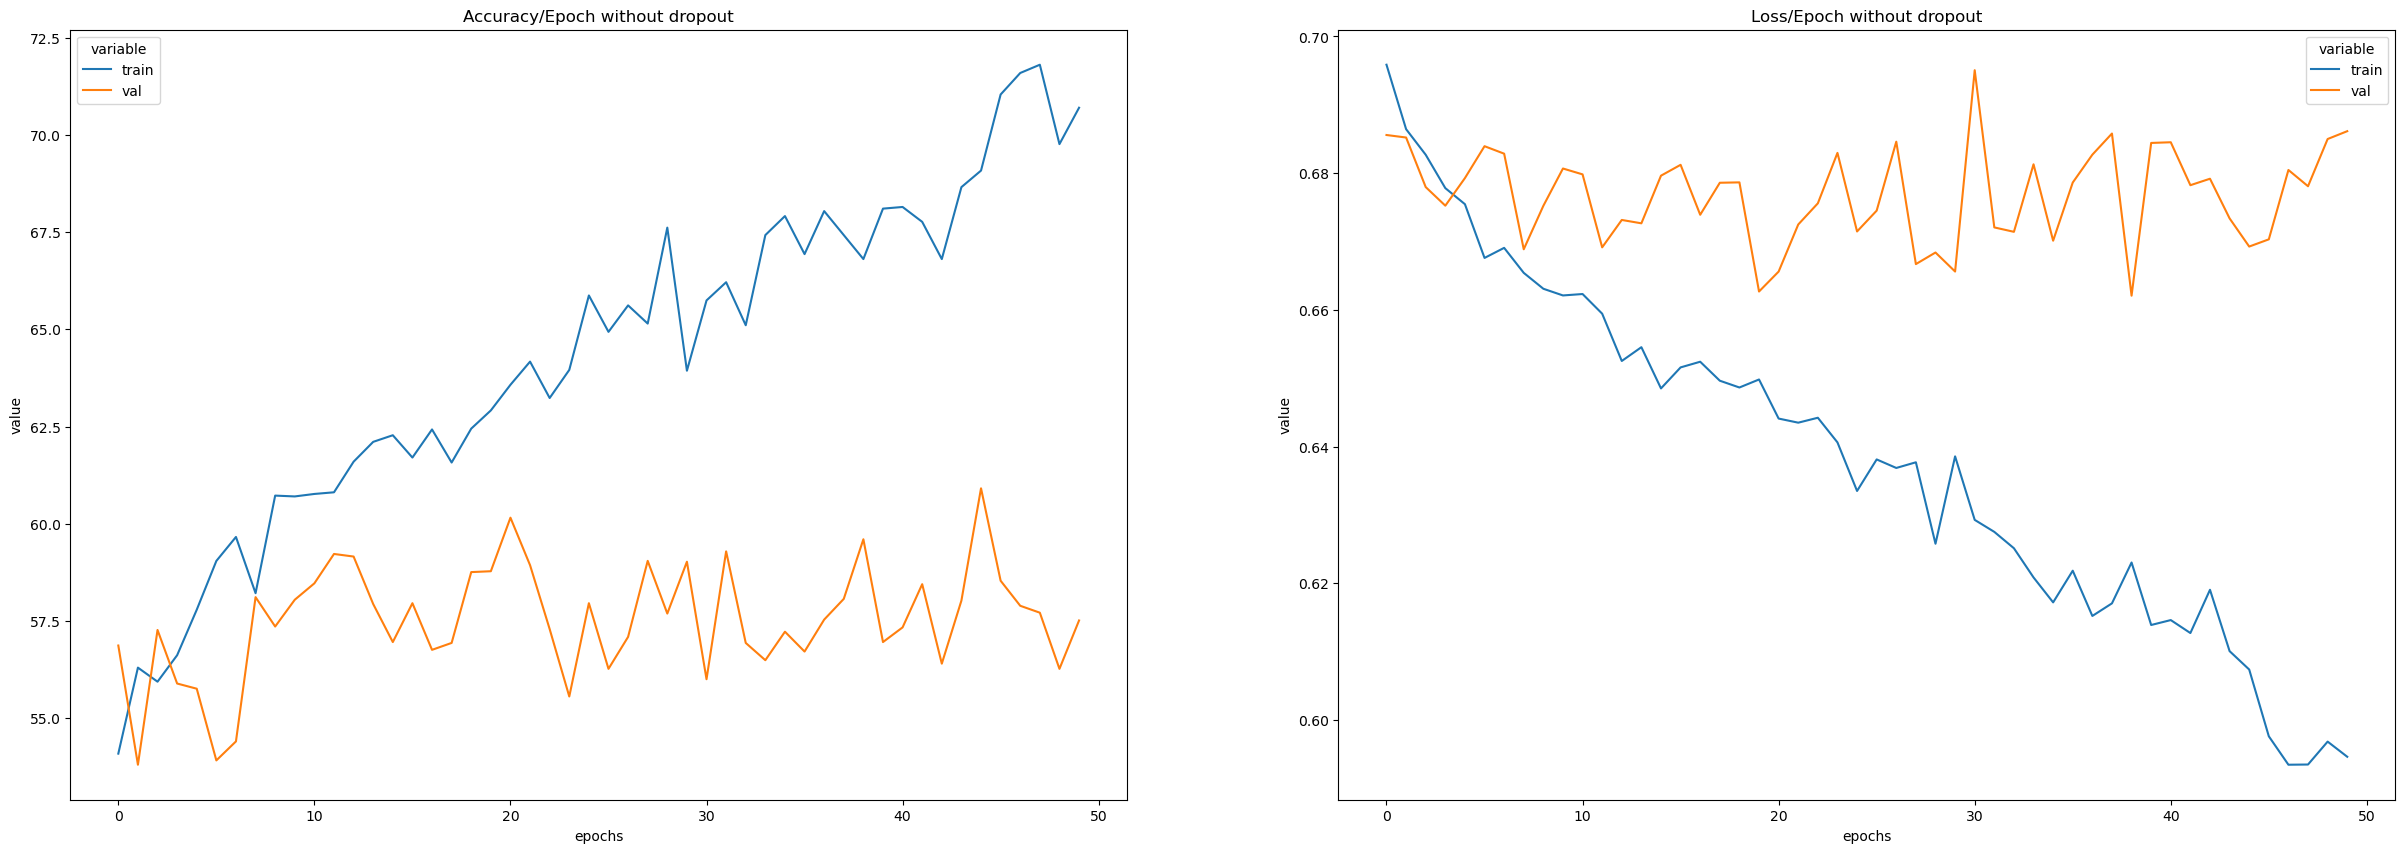

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))

sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable", ax = axes[0]).set_title('Accuracy/Epoch without dropout')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax = axes[1]).set_title('Loss/Epoch without dropout')
plt.show()

In [59]:
y_pred_list = []
y_true_list = []
model.eval()
with torch.no_grad():
    num_correct = 0
    total = 0
    #set_trace()
    for batch, (images, labels) in enumerate(testloader,1):
        pred = model(images)
        #output = torch.exp(logps)
        pred = torch.argmax(pred, 1)
        y_pred_list.append(pred.numpy())
        y_true_list.append(labels.numpy())
        total += labels.size(0)
        num_correct += (pred == labels).sum().item()
        #print('accuracy', binary_acc(pred, labels).item())
        print(f'Batch ({batch}/{len(testloader)})')
        
        #if batch == 7:
            #break

    print(f'Accuracy of the model on {total} test images: {num_correct * 100 / total}% ')

Batch (1/49)
Batch (2/49)
Batch (3/49)
Batch (4/49)
Batch (5/49)
Batch (6/49)
Batch (7/49)
Batch (8/49)
Batch (9/49)
Batch (10/49)
Batch (11/49)
Batch (12/49)
Batch (13/49)
Batch (14/49)
Batch (15/49)
Batch (16/49)
Batch (17/49)
Batch (18/49)
Batch (19/49)
Batch (20/49)
Batch (21/49)
Batch (22/49)
Batch (23/49)
Batch (24/49)
Batch (25/49)
Batch (26/49)
Batch (27/49)
Batch (28/49)
Batch (29/49)
Batch (30/49)
Batch (31/49)
Batch (32/49)
Batch (33/49)
Batch (34/49)
Batch (35/49)
Batch (36/49)
Batch (37/49)
Batch (38/49)
Batch (39/49)
Batch (40/49)
Batch (41/49)
Batch (42/49)
Batch (43/49)
Batch (44/49)
Batch (45/49)
Batch (46/49)
Batch (47/49)
Batch (48/49)
Batch (49/49)
Accuracy of the model on 781 test images: 59.92317541613316% 


In [60]:
exp_name = f"Neural Network without Regularization and Dropout"
expLog.loc[2,:4] = [f"{exp_name}"] + list(np.round(
               [accuracy_stats['train'][-1], 
                accuracy_stats['val'][-1],
                (num_correct * 100 / total)],3))
expLog

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


exp_name Train Acc Valid Acc  \
0  Baseline Neural Network without Augmentation, ...      97.9    56.022   
1  Neural Network without Augmentation and with R...    96.325    56.467   
2  Neural Network without Regularization and Dropout    70.702    57.511   

  Test  Acc  
0    56.978  
1    57.106  
2    59.923

In [61]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for batch, (images, labels) in enumerate(testloader,1):      
        y_test_pred = model(images)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)        
        y_pred_list = [*y_pred_list,*y_pred_tag.cpu().numpy()]
        y_true_list = [*y_true_list,*labels.cpu().numpy()]

In [62]:
y_pred_list_1 = np.array(y_pred_list).T
y_true_list_1 = np.array(y_true_list).T
#y_pred_list_1

In [63]:
print(classification_report(y_true_list_1, y_pred_list_1))

              precision    recall  f1-score   support

           0       0.62      0.57      0.59       402
           1       0.58      0.63      0.60       379

    accuracy                           0.60       781
   macro avg       0.60      0.60      0.60       781
weighted avg       0.60      0.60      0.60       781



In [64]:
print(confusion_matrix(y_true_list_1, y_pred_list_1))

[[229 173]
 [140 239]]


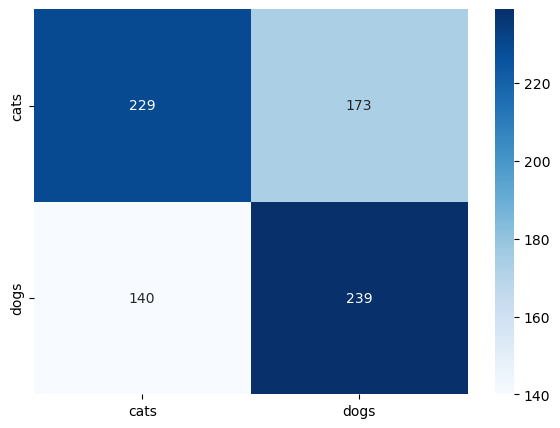

In [65]:
idx2class = {v: k for k, v in train_it.class_to_idx.items()}
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list_1, y_pred_list_1)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax, cmap = 'Blues', fmt = 'g')
plt.show()

# With Regularizaion and Without Dropout

In [70]:
from torch.optim import Adam
class cadod(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(128*128*3, 128)
        #self.fc2 = nn.Linear(1024,512)
        #self.fc3 = nn.Linear(512,128)
        self.fc4 = nn.Linear(128,64)
        self.fc5 = nn.Linear(64,2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        #self.norm1 = nn.BatchNorm1d(1024)
        self.norm2 = nn.BatchNorm1d(512)
        self.norm3 = nn.BatchNorm1d(128)
        self.norm4 = nn.BatchNorm1d(64)


    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        #x = self.norm1(x)
        #x = F.relu(self.fc2(x))
        #x = self.norm2(x)
        #x = F.relu(self.fc3(x))
        x = self.norm3(x)
        x = F.relu(self.fc4(x))
        x = self.norm4(x)
        #x =self.dropout(x)
        x = self.fc5(x) 
        x = F.softmax(x, dim = 1)
        return x

model = cadod()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, weight_decay = 3e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [500,1000,1500], gamma = 0.5)

In [71]:
model

cadod(
  (fc1): Linear(in_features=49152, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (norm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [72]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [73]:
model = model.to(device)
#optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()))

num_epochs = 50


for e in range(num_epochs):
    cum_epoch_loss = 0
    cum_acc = 0
    batch_loss = 0
    model.train()
    for batch, (images, labels) in enumerate(trainloader,1):
    #print(labels)
    #print(images.shape)
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        label_pred = model(images).squeeze()
        #print(logps)
        #break;
        #labels = labels.unsqueeze(1)
        loss = criterion(label_pred, labels)
        acc = binary_acc(label_pred, labels)
        loss.backward()
        optimizer.step()
        batch_loss += loss.item()
        cum_acc += acc.item()
        scheduler.step()
        #print(f'Epoch({e}/{num_epochs} : Batch number({batch}/{len(trainloader)})')
    
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for batch, (X_val_batch, y_val_batch) in enumerate(valloader,1):
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)            
            y_val_pred = model(X_val_batch).squeeze()
            #y_val_pred = torch.unsqueeze(y_val_pred, 0)            
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch)            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
        #print(f'Epoch({e}/{num_epochs} : Train loss : {loss.item()} : Train Accuracy : {acc.item()} : Valid loss : {val_loss.item()} : Valid Accuracy : {val_acc.item()}')
    
    loss_stats['train'].append(batch_loss/len(trainloader))
    loss_stats['val'].append(val_epoch_loss/len(valloader))
    accuracy_stats['train'].append(cum_acc/len(trainloader))
    accuracy_stats['val'].append(val_epoch_acc/len(valloader))
    
    print(f'Epoch({e}/{num_epochs})')
    print(f'Training loss : {batch_loss/len(trainloader)}')  
    print(f'Training accuracy : {cum_acc/len(trainloader)}')  
    print(f'Validation loss : {val_epoch_loss/len(valloader)}')  
    print(f'Validation accuracy : {val_epoch_acc/len(valloader)}') 
    

Epoch(0/50)
Training loss : 0.7074646315676101
Training accuracy : 51.53191489361702
Validation loss : 0.6924390620655484
Validation accuracy : 53.75555555555555
Epoch(1/50)
Training loss : 0.6898972113081749
Training accuracy : 55.08510638297872
Validation loss : 0.6938854349984063
Validation accuracy : 54.86666666666667
Epoch(2/50)
Training loss : 0.6837859470793541
Training accuracy : 54.61702127659574
Validation loss : 0.689277368121677
Validation accuracy : 56.17777777777778
Epoch(3/50)
Training loss : 0.6788228521955774
Training accuracy : 57.638297872340424
Validation loss : 0.6829059349166022
Validation accuracy : 55.977777777777774
Epoch(4/50)
Training loss : 0.6816198179062377
Training accuracy : 57.1063829787234
Validation loss : 0.6839883327484131
Validation accuracy : 55.91111111111111
Epoch(5/50)
Training loss : 0.6750124984599174
Training accuracy : 58.297872340425535
Validation loss : 0.6759995142618815
Validation accuracy : 59.06666666666667
Epoch(6/50)
Training loss :

In [74]:
round(sum(accuracy_stats['train'])/len(accuracy_stats['train']),2)

63.43

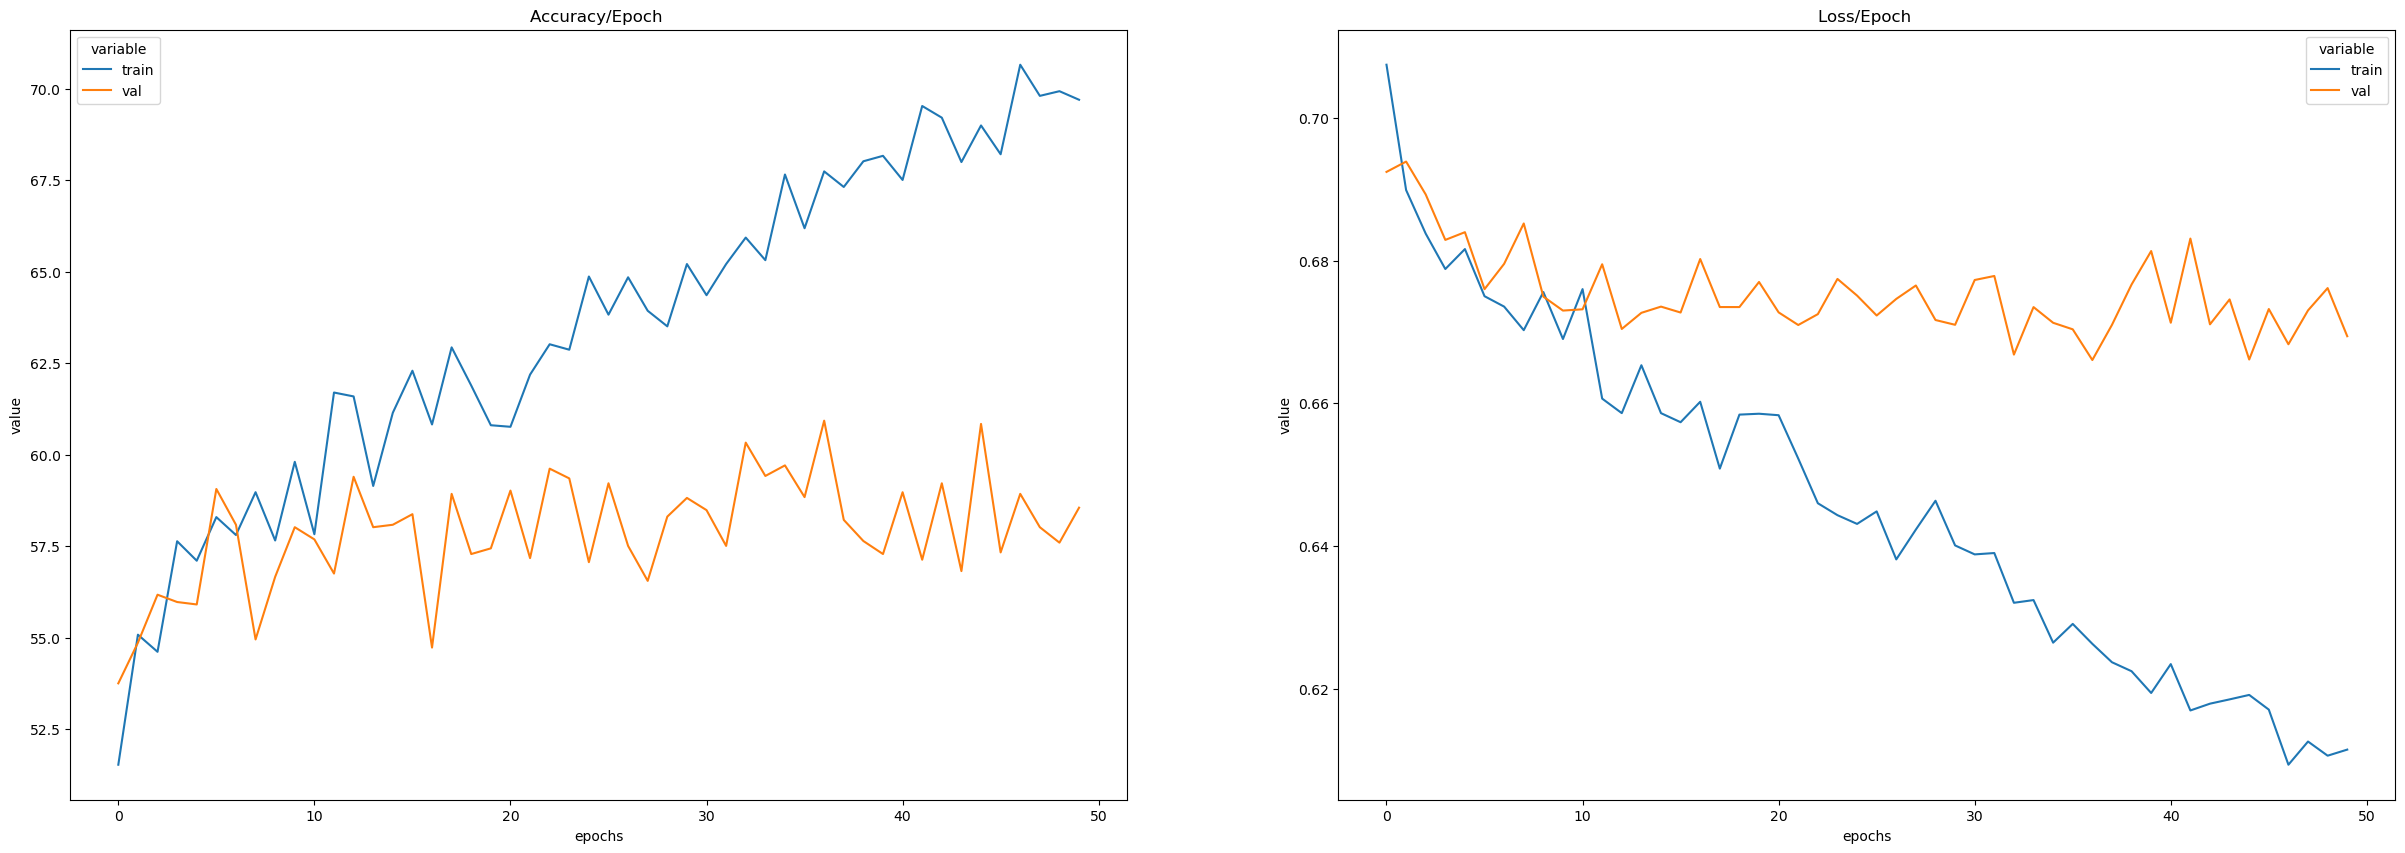

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))

sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable", ax = axes[0]).set_title('Accuracy/Epoch ')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax = axes[1]).set_title('Loss/Epoch ')
plt.show()

In [76]:
y_pred_list = []
y_true_list = []
model.eval()
with torch.no_grad():
    num_correct = 0
    total = 0
    #set_trace()
    for batch, (images, labels) in enumerate(testloader,1):
        pred = model(images)
        #output = torch.exp(logps)
        pred = torch.argmax(pred, 1)
        y_pred_list.append(pred.numpy())
        y_true_list.append(labels.numpy())
        total += labels.size(0)
        num_correct += (pred == labels).sum().item()
        #print('accuracy', binary_acc(pred, labels).item())
        print(f'Batch ({batch}/{len(testloader)})')
        
        #if batch == 7:
            #break

    print(f'Accuracy of the model on {total} test images: {num_correct * 100 / total}% ')

Batch (1/49)
Batch (2/49)
Batch (3/49)
Batch (4/49)
Batch (5/49)
Batch (6/49)
Batch (7/49)
Batch (8/49)
Batch (9/49)
Batch (10/49)
Batch (11/49)
Batch (12/49)
Batch (13/49)
Batch (14/49)
Batch (15/49)
Batch (16/49)
Batch (17/49)
Batch (18/49)
Batch (19/49)
Batch (20/49)
Batch (21/49)
Batch (22/49)
Batch (23/49)
Batch (24/49)
Batch (25/49)
Batch (26/49)
Batch (27/49)
Batch (28/49)
Batch (29/49)
Batch (30/49)
Batch (31/49)
Batch (32/49)
Batch (33/49)
Batch (34/49)
Batch (35/49)
Batch (36/49)
Batch (37/49)
Batch (38/49)
Batch (39/49)
Batch (40/49)
Batch (41/49)
Batch (42/49)
Batch (43/49)
Batch (44/49)
Batch (45/49)
Batch (46/49)
Batch (47/49)
Batch (48/49)
Batch (49/49)
Accuracy of the model on 781 test images: 57.87451984635083% 


In [77]:
exp_name = f"Neural Network without Dropout"
expLog.loc[3,:4] = [f"{exp_name}"] + list(np.round(
               [accuracy_stats['train'][-1], 
                accuracy_stats['val'][-1],
                (num_correct * 100 / total)],3))

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


In [78]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for batch, (images, labels) in enumerate(testloader,1):      
        y_test_pred = model(images)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)        
        y_pred_list = [*y_pred_list,*y_pred_tag.cpu().numpy()]
        y_true_list = [*y_true_list,*labels.cpu().numpy()]

In [79]:
y_pred_list_1 = np.array(y_pred_list).T
#y_pred_list_1

In [80]:
y_true_list_1 = np.array(y_true_list).T

In [81]:
print(classification_report(y_true_list_1, y_pred_list_1))

              precision    recall  f1-score   support

           0       0.61      0.52      0.56       402
           1       0.56      0.64      0.60       379

    accuracy                           0.58       781
   macro avg       0.58      0.58      0.58       781
weighted avg       0.58      0.58      0.58       781



In [82]:
print(confusion_matrix(y_true_list_1, y_pred_list_1))

[[209 193]
 [136 243]]


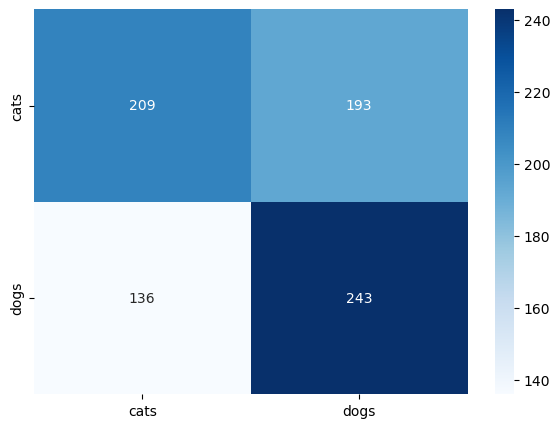

In [83]:
idx2class = {v: k for k, v in train_it.class_to_idx.items()}
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list_1, y_pred_list_1)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax, cmap = 'Blues', fmt = 'g')
plt.show()

# With Dropout

In [84]:
from torch.optim import Adam
class cadod(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(128*128*3, 128)
        #self.fc2 = nn.Linear(1024,512)
        #self.fc3 = nn.Linear(512,128)
        self.fc4 = nn.Linear(128,64)
        self.fc5 = nn.Linear(64,2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        #self.norm1 = nn.BatchNorm1d(1024)
        self.norm2 = nn.BatchNorm1d(512)
        self.norm3 = nn.BatchNorm1d(128)
        self.norm4 = nn.BatchNorm1d(64)


    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        #x = self.norm1(x)
        #x = F.relu(self.fc2(x))
        #x = self.norm2(x)
        #x = F.relu(self.fc3(x))
        x = self.norm3(x)
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.norm4(x)
        x = self.dropout(x)
        x = self.fc5(x) 
        x = F.softmax(x, dim = 1)
        return x

model = cadod()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, weight_decay = 3e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [500,1000,1500], gamma = 0.5)

In [85]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [86]:
model = model.to(device)
#optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()))

num_epochs = 50


for e in range(num_epochs):
    cum_epoch_loss = 0
    cum_acc = 0
    batch_loss = 0
    model.train()
    for batch, (images, labels) in enumerate(trainloader,1):
    #print(labels)
    #print(images.shape)
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        label_pred = model(images).squeeze()
        #print(logps)
        #break;
        #labels = labels.unsqueeze(1)
        loss = criterion(label_pred, labels)
        acc = binary_acc(label_pred, labels)
        loss.backward()
        optimizer.step()
        batch_loss += loss.item()
        cum_acc += acc.item()
        scheduler.step()
        #print(f'Epoch({e}/{num_epochs} : Batch number({batch}/{len(trainloader)})')
    
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for batch, (X_val_batch, y_val_batch) in enumerate(valloader,1):
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)            
            y_val_pred = model(X_val_batch).squeeze()
            #y_val_pred = torch.unsqueeze(y_val_pred, 0)            
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch)            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
        #print(f'Epoch({e}/{num_epochs} : Train loss : {loss.item()} : Train Accuracy : {acc.item()} : Valid loss : {val_loss.item()} : Valid Accuracy : {val_acc.item()}')
    
    loss_stats['train'].append(batch_loss/len(trainloader))
    loss_stats['val'].append(val_epoch_loss/len(valloader))
    accuracy_stats['train'].append(cum_acc/len(trainloader))
    accuracy_stats['val'].append(val_epoch_acc/len(valloader))
    
    print(f'Epoch({e}/{num_epochs})')
    print(f'Training loss : {batch_loss/len(trainloader)}')  
    print(f'Training accuracy : {cum_acc/len(trainloader)}')  
    print(f'Validation loss : {val_epoch_loss/len(valloader)}')  
    print(f'Validation accuracy : {val_epoch_acc/len(valloader)}') 
    

Epoch(0/50)
Training loss : 0.6995481886762254
Training accuracy : 53.1063829787234
Validation loss : 0.684781821568807
Validation accuracy : 56.022222222222226
Epoch(1/50)
Training loss : 0.6865724870499145
Training accuracy : 55.787234042553195
Validation loss : 0.6878685659832424
Validation accuracy : 52.77777777777778
Epoch(2/50)
Training loss : 0.6866932549375169
Training accuracy : 54.93617021276596
Validation loss : 0.6807456731796264
Validation accuracy : 56.93333333333333
Epoch(3/50)
Training loss : 0.6840045211162973
Training accuracy : 55.765957446808514
Validation loss : 0.6787495281961229
Validation accuracy : 56.888888888888886
Epoch(4/50)
Training loss : 0.6800109541162531
Training accuracy : 57.297872340425535
Validation loss : 0.6767797708511353
Validation accuracy : 55.68888888888889
Epoch(5/50)
Training loss : 0.6805504991653117
Training accuracy : 56.46808510638298
Validation loss : 0.6871784488360088
Validation accuracy : 54.6
Epoch(6/50)
Training loss : 0.67842027

In [87]:

train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))

sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable", ax = axes[0]).set_title('Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax = axes[1]).set_title('Loss/Epoch')
plt.show()

In [88]:
y_pred_list = []
y_true_list = []
model.eval()
with torch.no_grad():
    num_correct = 0
    total = 0
    #set_trace()
    for batch, (images, labels) in enumerate(testloader,1):
        pred = model(images)
        #output = torch.exp(logps)
        pred = torch.argmax(pred, 1)
        y_pred_list.append(pred.numpy())
        y_true_list.append(labels.numpy())
        total += labels.size(0)
        num_correct += (pred == labels).sum().item()
        #print('accuracy', binary_acc(pred, labels).item())
        print(f'Batch ({batch}/{len(testloader)})')
        
        #if batch == 7:
            #break

    print(f'Accuracy of the model on {total} test images: {num_correct * 100 / total}% ')

Batch (1/49)
Batch (2/49)
Batch (3/49)
Batch (4/49)
Batch (5/49)
Batch (6/49)
Batch (7/49)
Batch (8/49)
Batch (9/49)
Batch (10/49)
Batch (11/49)
Batch (12/49)
Batch (13/49)
Batch (14/49)
Batch (15/49)
Batch (16/49)
Batch (17/49)
Batch (18/49)
Batch (19/49)
Batch (20/49)
Batch (21/49)
Batch (22/49)
Batch (23/49)
Batch (24/49)
Batch (25/49)
Batch (26/49)
Batch (27/49)
Batch (28/49)
Batch (29/49)
Batch (30/49)
Batch (31/49)
Batch (32/49)
Batch (33/49)
Batch (34/49)
Batch (35/49)
Batch (36/49)
Batch (37/49)
Batch (38/49)
Batch (39/49)
Batch (40/49)
Batch (41/49)
Batch (42/49)
Batch (43/49)
Batch (44/49)
Batch (45/49)
Batch (46/49)
Batch (47/49)
Batch (48/49)
Batch (49/49)
Accuracy of the model on 781 test images: 58.25864276568502% 


In [89]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for batch, (images, labels) in enumerate(testloader,1):      
        y_test_pred = model(images)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)        
        y_pred_list = [*y_pred_list,*y_pred_tag.cpu().numpy()]
        y_true_list = [*y_true_list,*labels.cpu().numpy()]

In [90]:
exp_name = f"Neural Network with Dropout (p = 0.2)"
expLog.loc[4,:4] = [f"{exp_name}"] + list(np.round(
               [accuracy_stats['train'][-1], 
                accuracy_stats['val'][-1],
                (num_correct * 100 / total)],3))
expLog

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


exp_name Train Acc Valid Acc  \
0  Baseline Neural Network without Augmentation, ...      97.9    56.022   
1  Neural Network without Augmentation and with R...    96.325    56.467   
2  Neural Network without Regularization and Dropout    70.702    57.511   
3                     Neural Network without Dropout    69.702    58.556   
4              Neural Network with Dropout (p = 0.2)     63.83    57.644   

  Test  Acc  
0    56.978  
1    57.106  
2    59.923  
3    57.875  
4    58.259

In [91]:
y_pred_list_1 = np.array(y_pred_list).T
y_true_list_1 = np.array(y_true_list).T
#y_pred_list_1

In [92]:
print(classification_report(y_true_list_1, y_pred_list_1))

              precision    recall  f1-score   support

           0       0.59      0.62      0.61       402
           1       0.57      0.54      0.56       379

    accuracy                           0.58       781
   macro avg       0.58      0.58      0.58       781
weighted avg       0.58      0.58      0.58       781



In [93]:
print(confusion_matrix(y_true_list_1, y_pred_list_1))

[[251 151]
 [175 204]]


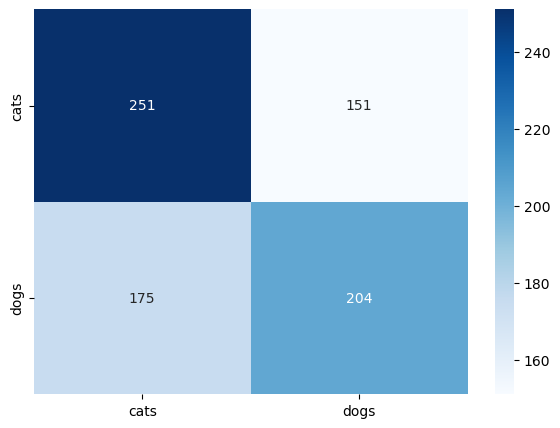

In [94]:
idx2class = {v: k for k, v in train_it.class_to_idx.items()}
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list_1, y_pred_list_1)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax, cmap = 'Blues', fmt = 'g')
plt.show()

## Drop out value of 0.1

In [95]:
from torch.optim import Adam
class cadod(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(128*128*3, 128)
        #self.fc2 = nn.Linear(1024,512)
        #self.fc3 = nn.Linear(512,128)
        self.fc4 = nn.Linear(128,64)
        self.fc5 = nn.Linear(64,2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        #self.norm1 = nn.BatchNorm1d(1024)
        self.norm2 = nn.BatchNorm1d(512)
        self.norm3 = nn.BatchNorm1d(128)
        self.norm4 = nn.BatchNorm1d(64)


    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        #x = self.norm1(x)
        #x = F.relu(self.fc2(x))
        #x = self.norm2(x)
        #x = F.relu(self.fc3(x))
        x = self.norm3(x)
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.norm4(x)
        x =self.dropout(x)
        x = self.fc5(x) 
        x = F.softmax(x, dim = 1)
        return x

model = cadod()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, weight_decay = 3e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [500,1000,1500], gamma = 0.5)

In [96]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [97]:
model = model.to(device)
#optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()))

num_epochs = 50


for e in range(num_epochs):
    cum_epoch_loss = 0
    cum_acc = 0
    batch_loss = 0
    model.train()
    for batch, (images, labels) in enumerate(trainloader,1):
    #print(labels)
    #print(images.shape)
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        label_pred = model(images).squeeze()
        #print(logps)
        #break;
        #labels = labels.unsqueeze(1)
        loss = criterion(label_pred, labels)
        acc = binary_acc(label_pred, labels)
        loss.backward()
        optimizer.step()
        batch_loss += loss.item()
        cum_acc += acc.item()
        scheduler.step()
        #print(f'Epoch({e}/{num_epochs} : Batch number({batch}/{len(trainloader)})')
    
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for batch, (X_val_batch, y_val_batch) in enumerate(valloader,1):
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)            
            y_val_pred = model(X_val_batch).squeeze()
            #y_val_pred = torch.unsqueeze(y_val_pred, 0)            
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch)            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
        #print(f'Epoch({e}/{num_epochs} : Train loss : {loss.item()} : Train Accuracy : {acc.item()} : Valid loss : {val_loss.item()} : Valid Accuracy : {val_acc.item()}')
    
    loss_stats['train'].append(batch_loss/len(trainloader))
    loss_stats['val'].append(val_epoch_loss/len(valloader))
    accuracy_stats['train'].append(cum_acc/len(trainloader))
    accuracy_stats['val'].append(val_epoch_acc/len(valloader))
    
    print(f'Epoch({e}/{num_epochs})')
    print(f'Training loss : {batch_loss/len(trainloader)}')  
    print(f'Training accuracy : {cum_acc/len(trainloader)}')  
    print(f'Validation loss : {val_epoch_loss/len(valloader)}')  
    print(f'Validation accuracy : {val_epoch_acc/len(valloader)}') 
    

Epoch(0/50)
Training loss : 0.7019766556455734
Training accuracy : 52.276595744680854
Validation loss : 0.6893682426876492
Validation accuracy : 54.55555555555556
Epoch(1/50)
Training loss : 0.6873131483159167
Training accuracy : 54.46808510638298
Validation loss : 0.6847085224257575
Validation accuracy : 55.51111111111111
Epoch(2/50)
Training loss : 0.6799716543644032
Training accuracy : 56.91489361702128
Validation loss : 0.6892028093338013
Validation accuracy : 53.55555555555556
Epoch(3/50)
Training loss : 0.6879159021884838
Training accuracy : 55.319148936170215
Validation loss : 0.6809960431522794
Validation accuracy : 55.955555555555556
Epoch(4/50)
Training loss : 0.6777490770563166
Training accuracy : 57.808510638297875
Validation loss : 0.6807383153173658
Validation accuracy : 56.48888888888889
Epoch(5/50)
Training loss : 0.67876409850222
Training accuracy : 57.42553191489362
Validation loss : 0.6690863993432786
Validation accuracy : 60.55555555555556
Epoch(6/50)
Training loss 

In [98]:

train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))

sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable", ax = axes[0]).set_title('Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax = axes[1]).set_title('Loss/Epoch')
plt.show()

In [99]:
y_pred_list = []
y_true_list = []
model.eval()
with torch.no_grad():
    num_correct = 0
    total = 0
    #set_trace()
    for batch, (images, labels) in enumerate(testloader,1):
        pred = model(images)
        #output = torch.exp(logps)
        pred = torch.argmax(pred, 1)
        y_pred_list.append(pred.numpy())
        y_true_list.append(labels.numpy())
        total += labels.size(0)
        num_correct += (pred == labels).sum().item()
        #print('accuracy', binary_acc(pred, labels).item())
        print(f'Batch ({batch}/{len(testloader)})')
        
        #if batch == 7:
            #break

    print(f'Accuracy of the model on {total} test images: {num_correct * 100 / total}% ')

Batch (1/49)
Batch (2/49)
Batch (3/49)
Batch (4/49)
Batch (5/49)
Batch (6/49)
Batch (7/49)
Batch (8/49)
Batch (9/49)
Batch (10/49)
Batch (11/49)
Batch (12/49)
Batch (13/49)
Batch (14/49)
Batch (15/49)
Batch (16/49)
Batch (17/49)
Batch (18/49)
Batch (19/49)
Batch (20/49)
Batch (21/49)
Batch (22/49)
Batch (23/49)
Batch (24/49)
Batch (25/49)
Batch (26/49)
Batch (27/49)
Batch (28/49)
Batch (29/49)
Batch (30/49)
Batch (31/49)
Batch (32/49)
Batch (33/49)
Batch (34/49)
Batch (35/49)
Batch (36/49)
Batch (37/49)
Batch (38/49)
Batch (39/49)
Batch (40/49)
Batch (41/49)
Batch (42/49)
Batch (43/49)
Batch (44/49)
Batch (45/49)
Batch (46/49)
Batch (47/49)
Batch (48/49)
Batch (49/49)
Accuracy of the model on 781 test images: 59.28297055057619% 


In [100]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for batch, (images, labels) in enumerate(testloader,1):      
        y_test_pred = model(images)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)        
        y_pred_list = [*y_pred_list,*y_pred_tag.cpu().numpy()]
        y_true_list = [*y_true_list,*labels.cpu().numpy()]

In [101]:
y_pred_list_1 = np.array(y_pred_list).T
y_true_list_1 = np.array(y_true_list).T
#y_pred_list_1

In [102]:
exp_name = f"Neural Network with Dropout (p = 0.1)"
expLog.loc[5,:4] = [f"{exp_name}"] + list(np.round(
               [accuracy_stats['train'][-1], 
                accuracy_stats['val'][-1],
                (num_correct * 100 / total)],3))
expLog

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


exp_name Train Acc Valid Acc  \
0  Baseline Neural Network without Augmentation, ...      97.9    56.022   
1  Neural Network without Augmentation and with R...    96.325    56.467   
2  Neural Network without Regularization and Dropout    70.702    57.511   
3                     Neural Network without Dropout    69.702    58.556   
4              Neural Network with Dropout (p = 0.2)     63.83    57.644   
5              Neural Network with Dropout (p = 0.1)     66.83    59.089   

  Test  Acc  
0    56.978  
1    57.106  
2    59.923  
3    57.875  
4    58.259  
5    59.283

In [103]:
y_pred_list_1 = np.array(y_pred_list).T
y_true_list_1 = np.array(y_true_list).T
#y_pred_list_1

In [104]:
print(classification_report(y_true_list_1, y_pred_list_1))

              precision    recall  f1-score   support

           0       0.61      0.57      0.59       402
           1       0.57      0.62      0.60       379

    accuracy                           0.59       781
   macro avg       0.59      0.59      0.59       781
weighted avg       0.59      0.59      0.59       781



In [105]:
print(confusion_matrix(y_true_list_1, y_pred_list_1))

[[229 173]
 [145 234]]


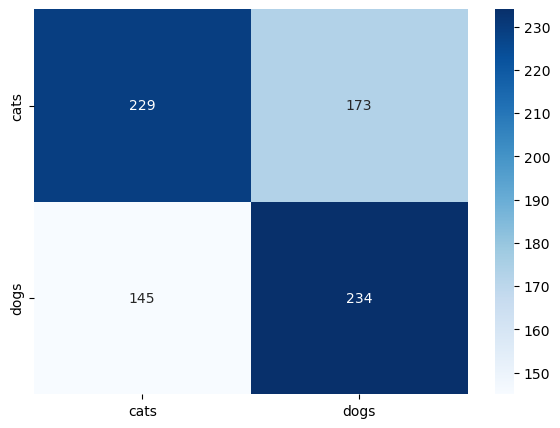

In [106]:
idx2class = {v: k for k, v in train_it.class_to_idx.items()}
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list_1, y_pred_list_1)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax, cmap = 'Blues', fmt = 'g')
plt.show()

# Results and Discussion

- Without augmentation, we see that though we got a training accuracy of more than 90%, the validation accuracy of only 56%, which clearly indicates that the model is overfitting the data 

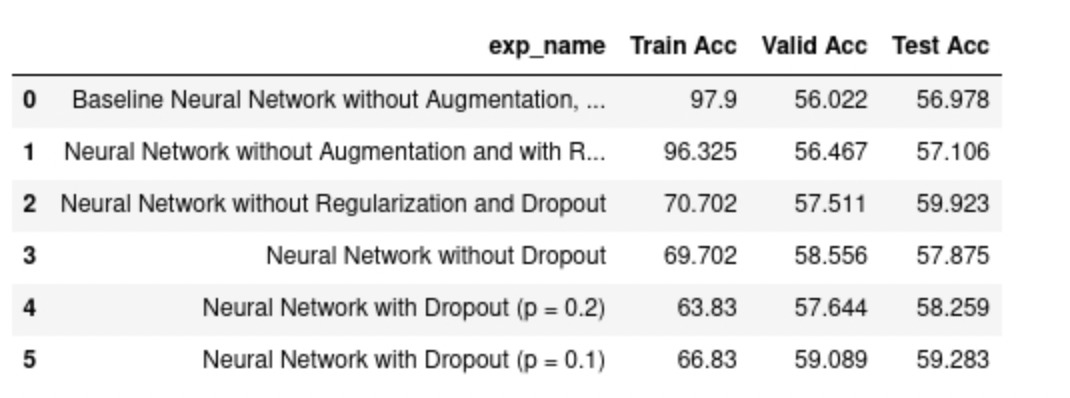


- Adding regularization did drop the test accuracy but not to a larger extent 

- We have overcome this by data augmentation, adding drop out layers and regularization 

- Our best model with a dropout layer of 0.1 yielded us a training accuracy of 67% and validation and test accuracy of ~60% 
- We also see that we also got a f1 score of ~60% for this model, with close to no difference in precision and recall values 

# MLP Regressor for Bounding Box prediction



### Sequential neural network regressor 

- Loss function used – MSE 

- We used a one input layer, 2 hidden layers, and an output layer in our neural network 

- Tanh was used the activation function 

- We also added multiple dropout layers to overcome overfitting 

- We have used Adam as our optimizer with a learning rate of 

- We also used a weight decay value of 1e-3 which will provide us with L2 regularization 

### A similar process was followed for OOP as well 

In [2]:
import torch
import torchvision
import torch.utils.data
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

from google.colab import drive
drive.mount('/content/drive')

!ls "/content/drive/My Drive/Colab Notebooks"


In [3]:
import numpy as np
X = np.load('data/img.npy', allow_pickle=True)
y_bbox = np.load('data/y_bbox.npy', allow_pickle=True)

In [4]:
print(X.shape, y_bbox.shape)

(12966, 49152) (12966, 4)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y_bbox, test_size=0.15, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [6]:
print(X_train.shape, y_train.shape)

(9367, 49152) (9367, 4)


In [32]:
!pip install torchsummary 

Defaulting to user installation because normal site-packages is not writeable


In [33]:
pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [7]:
from torchsummary import summary  #install it if necessary using !pip install torchsummary 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


## Scaling
scaler = StandardScaler()
X_train =      scaler.fit_transform(X_train).astype(float)
X_validation = scaler.transform(X_validation).astype(float) #Transform valid set with the same constants
X_test =       scaler.transform(X_test).astype(float)       #Transform test  set with the same constants

# convert numpy arrays to tensors
X_train_tensor = torch.from_numpy(X_train).float()
X_validation_tensor = torch.from_numpy(X_validation).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_train_tensor = torch.from_numpy(y_train).float()
y_test_tensor = torch.from_numpy(y_test).float()
y_validation_tensor = torch.from_numpy(y_validation).float()

# create TensorDataset in PyTorch
train_ds = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
validation_ds = torch.utils.data.TensorDataset(X_validation_tensor, y_validation_tensor)
test_ds = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
# create dataloader
batch_size = 96
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(validation_ds, batch_size=X_test.shape[0], shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=X_test.shape[0], shuffle=False, num_workers=0)


In [137]:
X_train.shape

(9367, 49152)

In [138]:
y_train.shape

(9367, 4)

In [139]:
D_in

49152

In [140]:
model = torch.nn.Sequential()

In [146]:
# Use the nn package to define our model and loss function.
# use the sequential API to create a neural network regressor

D_in = X_test.shape[1]
print(D_in)
D_hidden_1 =128
D_hidden_2 = 64
D_out = 4

model = torch.nn.Sequential(
    
    torch.nn.Linear(D_in, D_hidden_1),   
    nn.Tanh(),
    nn.Linear(D_hidden_1, D_hidden_2),
    nn.Tanh(),
    nn.Linear(in_features=D_hidden_2, out_features=D_out), 
    nn.Dropout(0.1)
    
)

     
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(f"We are working on a {device} device")


model.to(device) # put on GPU before setting up the optimizer




49152
We are working on a cpu device


Sequential(
  (0): Linear(in_features=49152, out_features=128, bias=True)
  (1): Tanh()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): Tanh()
  (4): Linear(in_features=64, out_features=4, bias=True)
  (5): Dropout(p=0.1, inplace=False)
)

In [147]:
model.to(device) 

Sequential(
  (0): Linear(in_features=49152, out_features=128, bias=True)
  (1): Tanh()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): Tanh()
  (4): Linear(in_features=64, out_features=4, bias=True)
  (5): Dropout(p=0.1, inplace=False)
)

In [148]:
loss_stats = {
    'train': [],
    "val": []
}

In [149]:
loss_fn = torch.nn.MSELoss(size_average=True)

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay = 0.005)

epochs = range(25)
count = 0 
running_loss = 0.0
for epoch in epochs:
    running_loss = 0.0
    for batch, data in enumerate(train_loader):
        # inputs, target = data[0].to(device), data[1].to(device)
        inputs, target = data[0], data[1]

        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()

        # do forward pass
        output = model(inputs.float())
        #print(output.shape, target.shape)
        # compute loss and gradients
        loss = loss_fn(output, torch.unsqueeze(target.float(), dim=1))
        
        # get gradients w.r.t to parameters
        loss.backward()

        # perform gradient update
        optimizer.step()

        # print statistics
        running_loss += loss.item()*inputs.size(0)
        count += inputs.size(0)
    print(f"Epoch {epoch+1}, Test MSE loss: {np.round(running_loss/count, 3)}")
    loss_stats['train'].append(running_loss/count)

#print('Finished Training')
#Model evaluation on validation set
    count = 0 
    running_loss = 0.0
    test_size = 0
    model.eval()
    for batch, data in enumerate(valid_loader):
       
        inputs, target = data[0], data[1]
        # do forward pass
        output = model(inputs.float())
        # compute loss and gradients
        loss = loss_fn(output, torch.unsqueeze(target.float(), dim=1))
        running_loss += loss.item()*inputs.size(0)
        count += inputs.size(0) 
        test_size += batch_size

    print(f"Validation  MSE loss: {np.round(running_loss/count, 3)}")
    
    loss_stats['val'].append(running_loss/count)

print("Finished Training!")

count = 0 
running_loss = 0.0
test_size = 0
model.eval()
for batch, data in enumerate(test_loader):
    
    inputs, target = data[0], data[1]
    # do forward pass
    output = model(inputs.float())
    # compute loss and gradients
    loss = loss_fn(output, torch.unsqueeze(target.float(), dim=1))
    # print statistics
    running_loss += loss.item()*inputs.size(0)
    count += inputs.size(0) 
    test_size += batch_size
print(f" Test  MSE loss: {np.round(running_loss/count, 3)}")

# predict test
# model.to(device)


/usr/local/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([96, 1, 4])) that is different to the input size (torch.Size([96, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([55, 1, 4])) that is different to the input size (torch.Size([55, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Test MSE loss: 0.524


/usr/local/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1654, 1, 4])) that is different to the input size (torch.Size([1654, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation  MSE loss: 0.456
Epoch 2, Test MSE loss: 0.359
Validation  MSE loss: 0.406
Epoch 3, Test MSE loss: 0.31
Validation  MSE loss: 0.352
Epoch 4, Test MSE loss: 0.261
Validation  MSE loss: 0.299
Epoch 5, Test MSE loss: 0.21
Validation  MSE loss: 0.243
Epoch 6, Test MSE loss: 0.158
Validation  MSE loss: 0.189
Epoch 7, Test MSE loss: 0.119
Validation  MSE loss: 0.153
Epoch 8, Test MSE loss: 0.089
Validation  MSE loss: 0.12
Epoch 9, Test MSE loss: 0.065
Validation  MSE loss: 0.095
Epoch 10, Test MSE loss: 0.049
Validation  MSE loss: 0.078
Epoch 11, Test MSE loss: 0.038
Validation  MSE loss: 0.062
Epoch 12, Test MSE loss: 0.03
Validation  MSE loss: 0.051
Epoch 13, Test MSE loss: 0.024
Validation  MSE loss: 0.042
Epoch 14, Test MSE loss: 0.02
Validation  MSE loss: 0.036
Epoch 15, Test MSE loss: 0.017
Validation  MSE loss: 0.03
Epoch 16, Test MSE loss: 0.015
Validation  MSE loss: 0.026
Epoch 17, Test MSE loss: 0.013
Validation  MSE loss: 0.024
Epoch 18, Test MSE loss: 0.013
Validation 

/usr/local/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1945, 1, 4])) that is different to the input size (torch.Size([1945, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [150]:
#Plotting train and avlidation MSE
import seaborn as sns
import matplotlib.pyplot as plt
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

#fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30,10))

sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Loss/Epoch')
plt.xlim([0,25])
plt.show()

In [151]:
expLog_R = pd.DataFrame(columns=["exp_name", 
                               "Train MSE", 
                               "Valid MSE",
                               "Test  MSE",
                              ])

In [152]:
#Logging the experiment
exp_name = f"Sequential Regression NN without dropout for weight_decay = 0.05"
expLog_R.loc[8,:4] = [f"{exp_name}"] + list(np.round(
               [loss_stats['train'][-1], 
                loss_stats['val'][-1],
                running_loss/count],3))
expLog_R

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


exp_name Train MSE Valid MSE  \
2         Sequential Regression NN Dropout (p = 0.5)     0.009     0.011   
0         Sequential Regression NN Dropout (p = 0.1)     0.009     0.011   
1         Sequential Regression NN Dropout (p = 0.2)      0.01     0.012   
3         Sequential Regression NN Dropout (p = 0.3)      0.01     0.013   
4         Sequential Regression NN Dropout (p = 0.4)      0.01     0.012   
5           Sequential Regression NN without dropout      0.01     0.012   
6  Sequential Regression NN without dropout for w...     0.009     0.011   
7  Sequential Regression NN without dropout for w...      0.01     0.022   
8  Sequential Regression NN without dropout for w...      0.01     0.012   

  Test  MSE  
2     0.011  
0     0.011  
1     0.012  
3     0.013  
4     0.012  
5     0.012  
6      0.01  
7     0.022  
8     0.012

# OOP API for Regression

In [19]:
D_in = 128*128*3
print(D_in)
D_hidden = 128
D_out = 4
# Use the nn package to define our model and loss function.
# use the sequential API makes things simple
class cadod_r(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(D_in, 128)

        self.fc4 = nn.Linear(128,64)
        self.fc5 = nn.Linear(64,4)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

        self.norm2 = nn.BatchNorm1d(512)
        self.norm3 = nn.BatchNorm1d(128)
        self.norm4 = nn.BatchNorm1d(64)


    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.tanh(self.fc1(x))
        x = self.dropout(x)
        x = F.tanh(self.fc4(x))

        x = self.dropout(x)
        x = self.fc5(x) 

        return x

model = cadod_r()
# MSE loss scaffolding layer
loss_fn = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005,weight_decay = 3e-4)

49152


In [20]:
loss_stats = {
    'train': [],
    "val": []
}

In [21]:
loss_fn = torch.nn.MSELoss(size_average=True)

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay = 0.005)

epochs = range(25)
count = 0 
running_loss = 0.0
for epoch in epochs:
    running_loss = 0.0
    for batch, data in enumerate(train_loader):
        # inputs, target = data[0].to(device), data[1].to(device)
        inputs, target = data[0], data[1]

        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()

        # do forward pass
        output = model(inputs.float())
        #print(output.shape, target.shape)
        # compute loss and gradients
        loss = loss_fn(output, torch.unsqueeze(target.float(), dim=1))
        
        # get gradients w.r.t to parameters
        loss.backward()

        # perform gradient update
        optimizer.step()

        # print statistics
        running_loss += loss.item()*inputs.size(0)
        count += inputs.size(0)
    print(f"Epoch {epoch+1}, Test MSE loss: {np.round(running_loss/count, 3)}")
    loss_stats['train'].append(running_loss/count)

#print('Finished Training')
#Model evaluation on validation set
    count = 0 
    running_loss = 0.0
    test_size = 0
    model.eval()
    for batch, data in enumerate(valid_loader):
       
        inputs, target = data[0], data[1]
        # do forward pass
        output = model(inputs.float())
        # compute loss and gradients
        loss = loss_fn(output, torch.unsqueeze(target.float(), dim=1))
        running_loss += loss.item()*inputs.size(0)
        count += inputs.size(0) 
        test_size += batch_size

    print(f"Validation  MSE loss: {np.round(running_loss/count, 3)}")
    
    loss_stats['val'].append(running_loss/count)

print("Finished Training!")

count = 0 
running_loss = 0.0
test_size = 0
model.eval()
for batch, data in enumerate(test_loader):
    
    inputs, target = data[0], data[1]
    # do forward pass
    output = model(inputs.float())
    # compute loss and gradients
    loss = loss_fn(output, torch.unsqueeze(target.float(), dim=1))
    # print statistics
    running_loss += loss.item()*inputs.size(0)
    count += inputs.size(0) 
    test_size += batch_size
print(f" Test  MSE loss: {np.round(running_loss/count, 3)}")

# predict test
# model.to(device)


/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([96, 1, 4])) that is different to the input size (torch.Size([96, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([55, 1, 4])) that is different to the input size (torch.Size([55, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Test MSE loss: 0.495


/usr/local/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1654, 1, 4])) that is different to the input size (torch.Size([1654, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation  MSE loss: 0.418
Epoch 2, Test MSE loss: 0.325
Validation  MSE loss: 0.365
Epoch 3, Test MSE loss: 0.273
Validation  MSE loss: 0.31
Epoch 4, Test MSE loss: 0.224
Validation  MSE loss: 0.259
Epoch 5, Test MSE loss: 0.179
Validation  MSE loss: 0.208
Epoch 6, Test MSE loss: 0.133
Validation  MSE loss: 0.162
Epoch 7, Test MSE loss: 0.095
Validation  MSE loss: 0.128
Epoch 8, Test MSE loss: 0.071
Validation  MSE loss: 0.106
Epoch 9, Test MSE loss: 0.056
Validation  MSE loss: 0.087
Epoch 10, Test MSE loss: 0.043
Validation  MSE loss: 0.074
Epoch 11, Test MSE loss: 0.034
Validation  MSE loss: 0.062
Epoch 12, Test MSE loss: 0.028
Validation  MSE loss: 0.053
Epoch 13, Test MSE loss: 0.025
Validation  MSE loss: 0.045
Epoch 14, Test MSE loss: 0.02
Validation  MSE loss: 0.037
Epoch 15, Test MSE loss: 0.017
Validation  MSE loss: 0.034
Epoch 16, Test MSE loss: 0.015
Validation  MSE loss: 0.029
Epoch 17, Test MSE loss: 0.014
Validation  MSE loss: 0.025
Epoch 18, Test MSE loss: 0.013
Validat

/usr/local/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1945, 1, 4])) that is different to the input size (torch.Size([1945, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


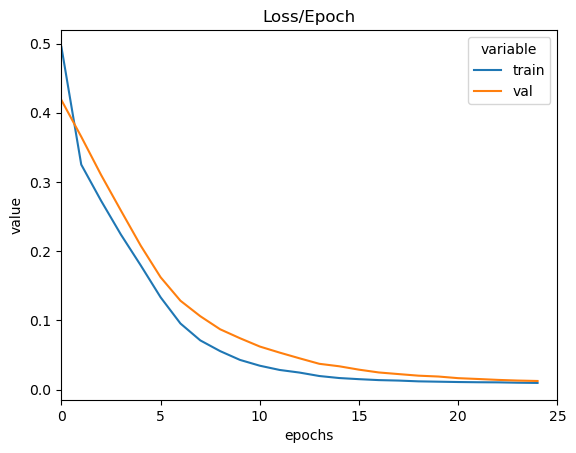

In [22]:
#Plotting train and avlidation MSE
import seaborn as sns
import matplotlib.pyplot as plt
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

#fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30,10))

sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Loss/Epoch')
plt.xlim([0,25])
plt.show()

In [27]:
expLog_RO = pd.DataFrame(columns=["exp_name", 
                               "Train MSE", 
                               "Valid MSE",
                               "Test  MSE",
                              ])

In [28]:
#Logging the experiment
exp_name = f"OOP API Regression"
expLog_RO.loc[0,:4] = [f"{exp_name}"] + list(np.round(
               [loss_stats['train'][-1], 
                loss_stats['val'][-1],
                running_loss/count],3))
expLog_RO

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


exp_name Train MSE Valid MSE Test  MSE
0  OOP API Regression      0.01     0.012     0.013

# Results and Discussion

- Regularization and dropout value of 0.1 worked well for regression as well. Our best model yielded a close to zero MSE for training, validation and test data set 

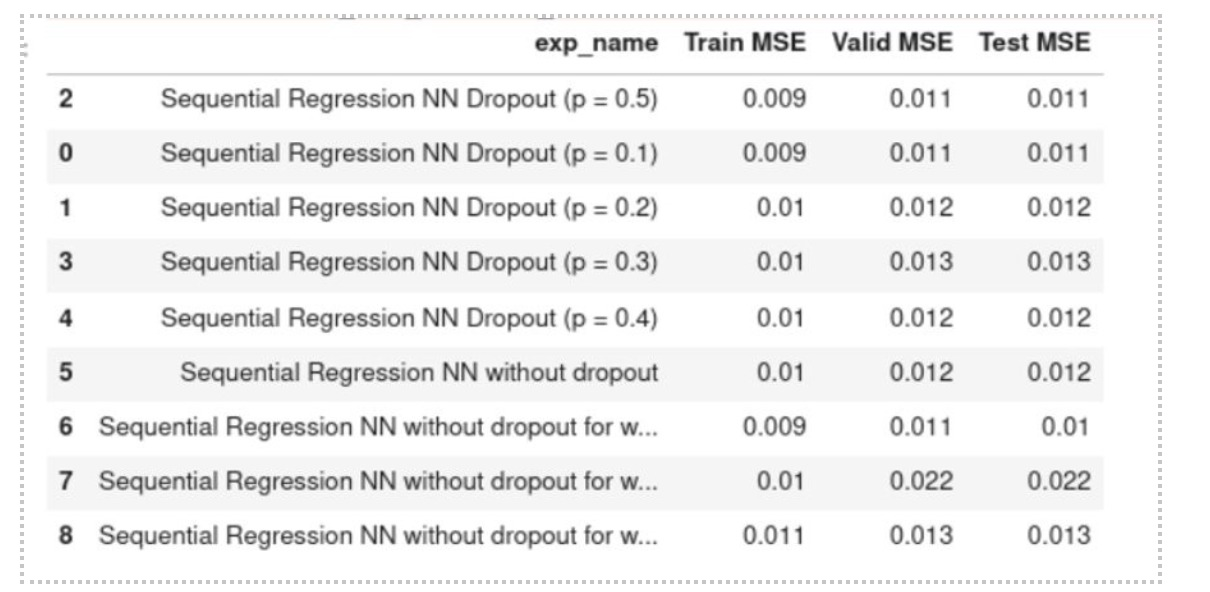



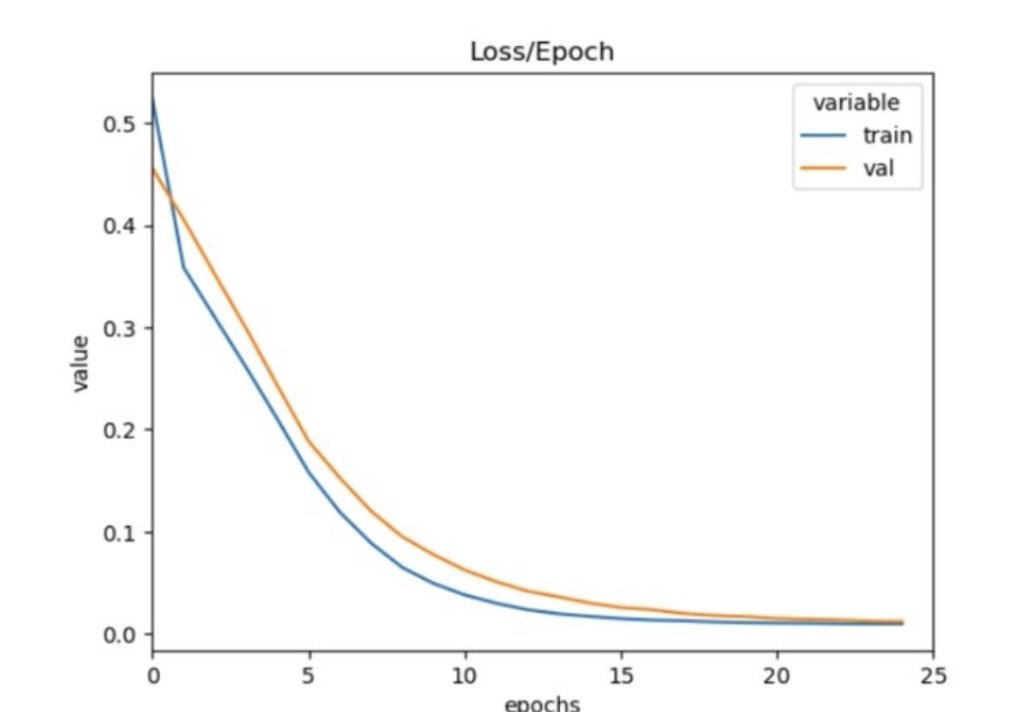

# Multiheaded CXE + MSE Network

- Steps to create the model: 

- Defined a model for classification and regression separately 

- For each epoch, we calculated CXE and MSE loss from the above models and then used the combined loss for back propagation 

- Adam optimizer was used to take the next step and update the weights and bias 

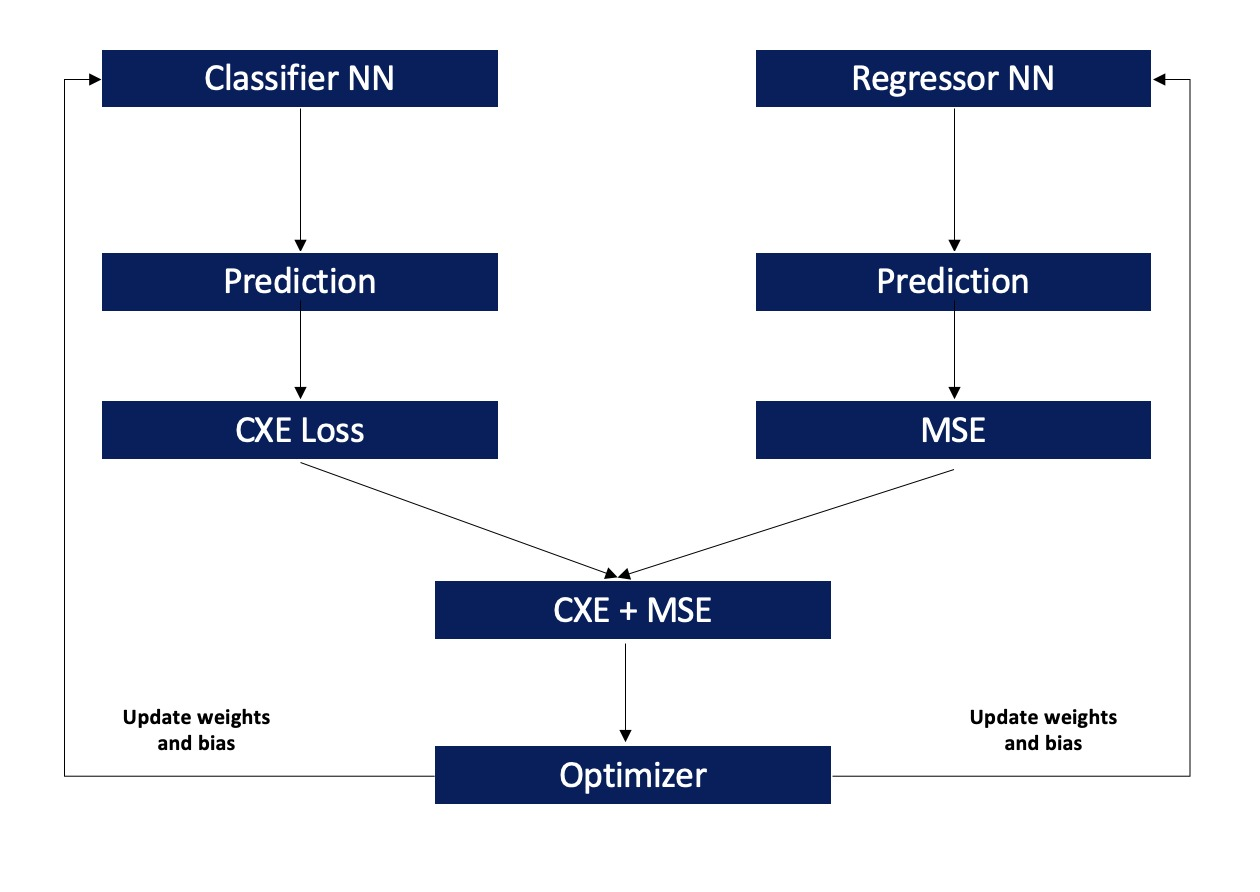


In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from torch.optim import Adam
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Setting seeds to try and ensure we have the same results - this is not guaranteed across PyTorch releases.
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, SubsetRandomSampler
import random
from os import listdir
from shutil import copyfile

In [4]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from os import makedirs

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
from tensorflow.keras import models
from tensorflow.keras.applications import *
from tensorflow.keras import layers



## Training from the MultiLayer Perceptron

In [7]:
#creating directories for test and train data set
dataset_home = 'cat_vs_dog/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['dogs/', 'cats/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		makedirs(newdir, exist_ok=True)

In [8]:
#load the csv file
df = pd.read_csv("cadod.csv")
df.head()


ImageID  Source  LabelName  Confidence      XMin      XMax  \
0  0000b9fcba019d36  xclick  /m/0bt9lr           1  0.165000  0.903750   
1  0000cb13febe0138  xclick  /m/0bt9lr           1  0.000000  0.651875   
2  0005a9520eb22c19  xclick  /m/0bt9lr           1  0.094167  0.611667   
3  0006303f02219b07  xclick  /m/0bt9lr           1  0.000000  0.999219   
4  00064d23bf997652  xclick  /m/0bt9lr           1  0.240938  0.906183   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.268333  0.998333           1            1  ...            0         0   
1  0.000000  0.999062           1            1  ...            0         0   
2  0.055626  0.998736           1            1  ...            0         0   
3  0.000000  0.998824           1            1  ...            0         0   
4  0.000000  0.694286           0            0  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.636250  0.903750  0.748750  0.165000  0.268333  0.506667  0.998333   
1  0.312500  0.000000  0.317500  0.651875  0.000000  0.410882  0.999062   
2  0.487500  0.611667  0.243333  0.094167  0.055626  0.226296  0.998736   
3  0.508594  0.999219  0.000000  0.478906  0.000000  0.375294  0.720000   
4  0.678038  0.906183  0.240938  0.522388  0.000000  0.370000  0.424286   

   XClick4Y  
0  0.661667  
1  0.999062  
2  0.305942  
3  0.998824  
4  0.694286  

[5 rows x 21 columns]

In [9]:
df.LabelName.replace({'/m/01yrx':'cat', '/m/0bt9lr':'dog'}, inplace=True)

In [10]:
dog_list = df[df.LabelName == 'dog']['ImageID']
cat_list = df[df.LabelName == 'cat']['ImageID']
#list(dog_list)

In [11]:
file_name_test = []
file_name_train = []

In [12]:

# moving images to test and train folder

random.seed(10)
# define ratio of pictures to use for test
test_ratio = 0.20
count_c = 0
count_d = 0

# copy training dataset images into subdirectories
src_directory = 'cadod/'
for file in listdir(src_directory):
    #print(file.replace('.jpg','').replace('._','') in list(cat_list))
    #print(file.replace('.jpg','').replace('._','') in list(dog_list))
    src = src_directory + '/' + file
    dst_dir = 'train/'
    if random.random() < test_ratio:
        dst_dir = 'test/'
        file_name_test.append(file.replace('.jpg','').replace('._',''))
    if file.replace('.jpg','').replace('._','') in list(cat_list) and count_c < 500:
        dst = dataset_home + dst_dir + 'cats/'  + file
        count_c +=1
        copyfile(src, dst)
        file_name_train.append(file.replace('.jpg','').replace('._',''))
    elif file.replace('.jpg','').replace('._','') in list(dog_list) and count_d < 500:
        dst = dataset_home + dst_dir + 'dogs/'  + file
        count_d +=1
        copyfile(src, dst)
        file_name_train.append(file.replace('.jpg','').replace('._',''))

In [13]:
train_id = pd.DataFrame (file_name_train, columns = ['ImageID'])
train_id.head()

ImageID
0  2b55a824f4a375d3
1  bc26925fd646efe5
2  f8fccbefa2e8e33f
3  9c730899f38007cc
4  01901b6370020f3c

In [14]:
test_id = pd.DataFrame (file_name_test, columns = ['ImageID'])
test_id.head()

ImageID
0  d00eb685487904b0
1  ddfc5237d20952a7
2  e60d548f2f124a01
3  f4add7bb2ee11f8d
4  8054527db8754ab1

In [15]:
df.ImageID.astype('O')
train_id.ImageID.astype('O')
df_n = df[['ImageID','XMin', 'YMin', 'XMax', 'YMax']]
df_n.set_index('ImageID')
train_id.set_index('ImageID')
train_id_n = df_n.join(train_id, how = 'left', lsuffix = '_left', rsuffix = '_right')
train_id_n.drop(columns = ['ImageID_right'], inplace = True)
train_id_n.head(5)

ImageID_left      XMin      YMin      XMax      YMax
0  0000b9fcba019d36  0.165000  0.268333  0.903750  0.998333
1  0000cb13febe0138  0.000000  0.000000  0.651875  0.999062
2  0005a9520eb22c19  0.094167  0.055626  0.611667  0.998736
3  0006303f02219b07  0.000000  0.000000  0.999219  0.998824
4  00064d23bf997652  0.240938  0.000000  0.906183  0.694286

In [16]:
df.ImageID.astype('O')
test_id.ImageID.astype('O')
#df.set_index('ImageID')
test_id.set_index('ImageID')
test_id_n = df_n.join(test_id, how = 'left', lsuffix = '_left', rsuffix = '_right')
test_id_n.drop(columns = ['ImageID_right'], inplace = True)
test_id_n.head(5)

ImageID_left      XMin      YMin      XMax      YMax
0  0000b9fcba019d36  0.165000  0.268333  0.903750  0.998333
1  0000cb13febe0138  0.000000  0.000000  0.651875  0.999062
2  0005a9520eb22c19  0.094167  0.055626  0.611667  0.998736
3  0006303f02219b07  0.000000  0.000000  0.999219  0.998824
4  00064d23bf997652  0.240938  0.000000  0.906183  0.694286

In [17]:
expLog = pd.DataFrame(columns=["exp_name", 
                               "Train Loss", 
                               "Valid Loss",
                               "Test Loss",
                              ])

### Image Classification

In [18]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform_test = transforms.Compose([
    #transforms.ToPILImage(),             
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])
transform_train = transforms.Compose([
    #transforms.ToPILImage(),             
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(40),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    #transforms.RandomAutocontrast()
    
    ])

In [19]:
train_it = datasets.ImageFolder('cat_vs_dog/train/', transform=transform_train)
test_it = datasets.ImageFolder('cat_vs_dog/test/', transform=transform_test)

dataset_size = len(train_it)
dataset_indices = list(range(dataset_size))
np.random.shuffle(dataset_indices)

In [20]:
dataset_size

800

In [21]:
idx2class = {v: k for k, v in train_it.class_to_idx.items()}
idx2class

{0: 'cats', 1: 'dogs'}

In [22]:
dataset_size = len(train_it)
dataset_indices = list(range(dataset_size))
#dataset_indices[val_split_index:]

In [23]:
np.random.shuffle(dataset_indices)

In [24]:
val_split_index = int(np.floor(0.2 * dataset_size))

In [25]:
train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]

In [26]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [27]:
bs_train = 16
bs_test = 4
bs_valid = 8
trainloader = DataLoader(dataset=train_it, shuffle=False, batch_size=bs_train, sampler=train_idx)
valloader = DataLoader(dataset=train_it, shuffle=False, batch_size=bs_valid, sampler=val_idx)
testloader = DataLoader(test_it, batch_size=bs_test, shuffle=False)

In [28]:
y_box_train = train_id_n[val_split_index:]
y_box_val =  train_id_n[:val_split_index]
y_box_val.shape

(160, 5)

In [29]:
for images, labels in trainloader:
    print(images.size(), labels.size())
    print(labels)
    break

torch.Size([16, 3, 128, 128]) torch.Size([16])
tensor([1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0])


In [30]:
for images, labels in valloader:
    print(images.size(), labels.size())
    print(labels)
    break

torch.Size([8, 3, 128, 128]) torch.Size([8])
tensor([0, 0, 1, 1, 0, 1, 0, 1])


In [31]:
import numpy as np
X = np.load('data/img.npy', allow_pickle=True)
y_label = np.load('data/y_label.npy', allow_pickle=True)
y_bbox = np.load('data/y_bbox.npy', allow_pickle=True)

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [33]:
y_train_tensor = torch.from_numpy(y_box_train[['XMin', 'YMin', 'XMax', 'YMax']].to_numpy())
y_val_tensor = torch.from_numpy(y_box_val[['XMin', 'YMin', 'XMax', 'YMax']].to_numpy())
y_test_tensor = torch.from_numpy(test_id_n[['XMin', 'YMin', 'XMax', 'YMax']].to_numpy())
#y_val_tensor

# Classifier model

In [34]:
from torch.optim import Adam
class cadod_c(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(128*128*3, 128)
        #self.fc2 = nn.Linear(1024,512)
        #self.fc3 = nn.Linear(512,128)
        self.fc4 = nn.Linear(128,64)
        self.fc5 = nn.Linear(64,2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        #self.norm1 = nn.BatchNorm1d(1024)
        self.norm2 = nn.BatchNorm1d(512)
        self.norm3 = nn.BatchNorm1d(128)
        self.norm4 = nn.BatchNorm1d(64)


    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))

        x = self.norm3(x)
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.norm4(x)
        x =self.dropout(x)
        x = self.fc5(x) 
        x = F.softmax(x, dim = 1)
        return x

model_c = cadod_c()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_c.parameters(), lr=0.0002, weight_decay = 3e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [500,1000,1500], gamma = 0.5)

# Regressor model

In [36]:
D_in = 128*128*3
print(D_in)
D_hidden = 128
D_out = 4
# Use the nn package to define our model and loss function.
# use the sequential API makes things simple
class cadod_r(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(D_in, 128)
        #self.fc2 = nn.Linear(1024,512)
        #self.fc3 = nn.Linear(512,128)
        self.fc4 = nn.Linear(128,64)
        self.fc5 = nn.Linear(64,4)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        #self.norm1 = nn.BatchNorm1d(1024)
        self.norm2 = nn.BatchNorm1d(512)
        self.norm3 = nn.BatchNorm1d(128)
        self.norm4 = nn.BatchNorm1d(64)


    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.tanh(self.fc1(x))
        #x = self.norm1(x)
        #x = F.relu(self.fc2(x))
        #x = self.norm2(x)
        #x = F.relu(self.fc3(x))
        #x = self.norm3(x)
        x = self.dropout(x)
        x = F.tanh(self.fc4(x))
        #x = self.norm4(x)
        x = self.dropout(x)
        x = self.fc5(x) 
        #x = F.softmax(x, dim = 1)
        return x

model_r = cadod_r()
# MSE loss scaffolding layer
loss_fn = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model_r.parameters(), lr=0.0005,weight_decay = 3e-4)

49152


In [37]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [38]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)    
    correct_results_sum = (y_pred_tags == y_test).sum().float()    
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)    
    return acc

# Multi headed model

In [39]:
model_c = model_c.to(device)
model_r = model_r.to(device)


num_epochs = 50


for e in range(num_epochs):
    cum_epoch_loss = 0
    cum_acc = 0
    batch_loss = 0
    mse_loss = 0
    train = 0
    test = 0
    val = 0
    model_c.train()
    model_r.train()
    #Training the model
    for batch, (images, labels) in enumerate(trainloader,1):
        
        images = images.to(device)
        labels = labels.to(device)
        #images_2 = images_2.to(device)
        
        bbox = y_train_tensor[train:train+bs_train].to(device)
        train +=bs_train
        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()
        label_pred = model_c(images).squeeze()  #training the classifier model
        box_pred = model_r(images)  #training the regressor model
        loss_1 = criterion(label_pred, labels) #CXE loss
        acc = binary_acc(label_pred, labels)
        loss_2 = loss_fn(box_pred, torch.unsqueeze(bbox.float(), dim=1)) #MSE
        loss = loss_1 + loss_2 #combined loss
        loss.backward() #backpropagating loss
        optimizer.step()  #gradient update
        batch_loss += loss.item()
        cum_acc += acc.item()
        
        scheduler.step()
        #print(f'Epoch({e}/{num_epochs} : Batch number({batch}/{len(trainloader)})')
    
    #Evaluating the model on validation set
    with torch.no_grad():
        model_c.eval()
        model_r.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        val = 0
        for batch, (X_val_batch, y_val_batch) in enumerate(valloader,1):
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_box_val = y_val_tensor[val:val+bs_valid].to(device)
            
            y_val_pred = model_c(X_val_batch).squeeze()
            y_box_pred = model_r(X_val_batch).squeeze()
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch) 
            
            mse_loss = loss_fn(y_box_pred, torch.unsqueeze(y_box_val.float(), dim=1))
            
            val_epoch_loss += val_loss.item() + mse_loss.item()
            val_epoch_acc += val_acc.item()
            val += bs_valid
            
     #saving the results for plotting   
    loss_stats['train'].append(batch_loss/len(trainloader))
    loss_stats['val'].append(val_epoch_loss/len(valloader))
    accuracy_stats['train'].append(cum_acc/len(trainloader))
    accuracy_stats['val'].append(val_epoch_acc/len(valloader))
    
    print(f'Epoch({e}/{num_epochs})')
    print(f'Training loss : {batch_loss/len(trainloader)}')  
    print(f'Training accuracy : {cum_acc/len(trainloader)}')  
    print(f'Validation loss : {val_epoch_loss/len(valloader)}')  
    print(f'Validation accuracy : {val_epoch_acc/len(valloader)}') 
    

/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([16, 1, 4])) that is different to the input size (torch.Size([16, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#

Epoch(0/50)
Training loss : 0.879992139339447
Training accuracy : 47.05
Validation loss : 0.8160292257554829
Validation accuracy : 42.0
Epoch(1/50)
Training loss : 0.8147073850035668
Training accuracy : 50.225
Validation loss : 0.7857627982273698
Validation accuracy : 43.8
Epoch(2/50)
Training loss : 0.797081308066845
Training accuracy : 47.95
Validation loss : 0.7427065202966332
Validation accuracy : 56.65
Epoch(3/50)
Training loss : 0.7843752071261406
Training accuracy : 46.55
Validation loss : 0.7327043810859323
Validation accuracy : 54.35
Epoch(4/50)
Training loss : 0.776068665087223
Training accuracy : 47.15
Validation loss : 0.7662655789870769
Validation accuracy : 44.55
Epoch(5/50)
Training loss : 0.778938265144825
Training accuracy : 48.275
Validation loss : 0.7574834938161075
Validation accuracy : 49.35
Epoch(6/50)
Training loss : 0.7841269075870514
Training accuracy : 49.75
Validation loss : 0.7543694017920644
Validation accuracy : 47.45
Epoch(7/50)
Training loss : 0.76467727

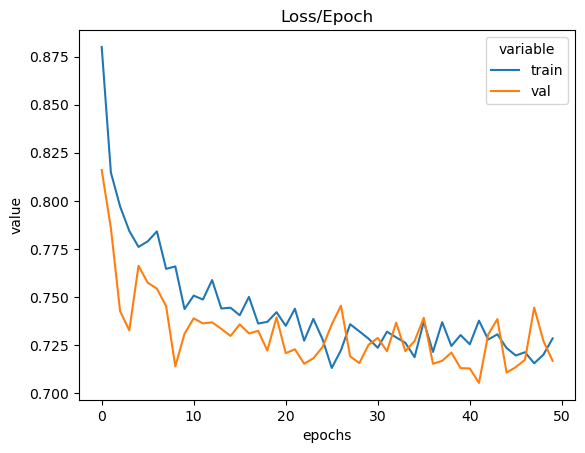

In [40]:
#Plotting training and validation loss

train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Loss/Epoch')

plt.show()

In [48]:
#Getting testing loss
y_pred_list = []
y_true_list = []
#model.eval()
#with torch.no_grad():
with torch.no_grad():
        model_c.eval()
        model_r.eval()
        test_epoch_loss = 0
        test_epoch_acc = 0
        #val_mse_loss = 0
        test = 0
        for batch, (X_test_batch, y_test_batch) in enumerate(testloader,1):
            X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            y_box_test = y_test_tensor[test:test+bs_valid].to(device)
            #print(y_box_val)
            y_test_pred = model_c(X_test_batch).squeeze()
            y_box_pred = model_r(X_test_batch).squeeze()
            #y_val_pred = torch.unsqueeze(y_val_pred, 0)            
            test_loss = criterion(y_test_pred, y_test_batch)
            test_acc = binary_acc(y_test_pred, y_test_batch) 
            #print(y_box_val)
            #print(y_box_pred)
            mse_loss = loss_fn(y_box_pred, torch.unsqueeze(y_box_test.float(), dim=1))
            #print(val_loss.item(),mse_loss.item())
            test_epoch_loss += test_loss.item() + mse_loss.item()
            test_epoch_acc += test_acc.item()
            test += bs_valid
            
        

        #print(f'Epoch({e}/{num_epochs})')
        print(f'Test loss : {test_epoch_loss/len(testloader)}')  
          
        

/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([8, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test loss : 0.7493907929956913


# Result and Discussions

- Combining the loss of classification and regression model to backpropagate the loss to improve the model 

- We trained the model for 50 epochs and saw that both train and validation loss decreased steadily after each epoch 

    - At the end of all the epochs, we ended up with a loss close to 0.7



# Conclusion: 

Our main objective was to classify images of cats and dogs and to identify the location. This fundamental problem in computer vision is the basis of many other computer vision tasks. In the phase, we used neural networks with data augmentation, drop out layers and regularization to make the prediction, which reduced overfitting the model and yielded us with an accuracy of ~60%. In addition to this, we also combined the CXE and MSE loss and then sent it back for optimization of the neural network which helped us reduce the loss steadily after each epoch.

### Our next steps will be as follows:
- Fine tune the existing CNN model by adding dropout layers, batchnorm layer, and maxpooling layer
    - Also, we plan to experiment with regularization and different types of optimizers
- Build a transfer learning network using efficient det
- Perform a t-test to compare the baseline model with the improved model to make sure our improved model performs significantly better than the models from the previous phases
